The goal of this notebook is to determine which cytokines and chemokines are found at high levels in pyroptotic inducing agents.
Doing this will allow us to determine ground truth of pyroptosis occurance.

### Imports

In [1]:
import pathlib

# umap analysis of treatment groups
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import toml
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from scipy.cluster.hierarchy import linkage
from scipy.stats import f_oneway

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# anova test on each group


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)
import umap

In [2]:
# set path
df_path = pathlib.Path(
    f"../../Data/clean/Plate2/nELISA_plate_430420_PBMC_cleanup4correlation.csv"
)
# read in the data
df = pd.read_csv(df_path)

In [3]:
# import selected treatmenets
# set path
toml_path = pathlib.Path("../../../1.Exploratory_Data_Analysis/utils/params.toml")

# read in toml file
params = toml.load(toml_path)
list_of_treatments = params["list_of_treatments"]["treatments"]

In [4]:
# get the treatments in fourb_Metadata_Treatment_Dose_Inhibitor coulumn for each treatment in the list of treatments
# df = df[df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(list_of_treatments)]
df = df.drop(
    columns=["Metadata_position_x", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)

## Anova and Post-Hoc Analysis
Anova of all treatments and post-hoc analysis of all treatments for each cytokine and chemokine. 
This will determine the cytokines and chemokines that are found at high levels in pyroptotic inducing agents.

In [5]:
# define blank df
final_df_tukey = pd.DataFrame(
    {
        "group1": [""],
        "group2": [""],
        "meandiff": [""],
        "lower": [""],
        "upper": [""],
        "reject": [""],
        "p-adj": [""],
        "cytokine": [""],
    }
)

In [6]:
# perform anova on each column of the data frame with oneb_meta as the groupby
num = 0
alpha = 0.05
alpha_adj = alpha / (len(df.columns) - 1)
for i in df.columns:
    for treatment in list_of_treatments:
        if i == "fourb_Metadata_Treatment_Dose_Inhibitor_Dose":
            continue
        one_way_anova = stats.f_oneway(
            df[i][df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"] == treatment],
            df[i][df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"] != treatment],
        )
        if one_way_anova.pvalue < alpha:
            num += 1
            tukey = pairwise_tukeyhsd(
                endog=df[i],
                groups=df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"],
                alpha=alpha_adj,
            )
            # send the results to a dataframe
            tukey_results = pd.DataFrame(
                data=tukey._results_table.data[1:], columns=tukey._results_table.data[0]
            )
            tukey_results["cytokine"] = f"{i}"
            # concat the results to the blank df
            final_df_tukey = pd.concat([final_df_tukey, tukey_results], axis=0)
        else:
            pass
print(
    f"Out of the {len(df.columns ) - 1} cytokines tested, {num} were significantly different between groups (p < {alpha})"
)

Out of the 187 cytokines tested, 489 were significantly different between groups (p < 0.05)


In [7]:
# check for blank first row...
final_df_tukey.head(3)

group1                           group2 meandiff   lower  \
0                                                                               
0  DMSO__0.100__DMSO__0.025         DMSO__0.100__DMSO__1.000  -0.0345 -0.1631   
1  DMSO__0.100__DMSO__0.025  DMSO__0.100__Z-VAD-FMK__100.000  -0.0308 -0.1594   

    upper reject p-adj         cytokine  
0                                        
0  0.0941  False   1.0  Activin A [NSU]  
1  0.0978  False   1.0  Activin A [NSU]

In [8]:
# remove first row as it is blank fro some reason
final_df_tukey = final_df_tukey.iloc[1:]
final_df_tukey.head(3)

group1                           group2 meandiff   lower  \
0  DMSO__0.100__DMSO__0.025         DMSO__0.100__DMSO__1.000  -0.0345 -0.1631   
1  DMSO__0.100__DMSO__0.025  DMSO__0.100__Z-VAD-FMK__100.000  -0.0308 -0.1594   
2  DMSO__0.100__DMSO__0.025   DMSO__0.100__Z-VAD-FMK__30.000  -0.0245 -0.1531   

    upper reject p-adj         cytokine  
0  0.0941  False   1.0  Activin A [NSU]  
1  0.0978  False   1.0  Activin A [NSU]  
2  0.1041  False   1.0  Activin A [NSU]

Clean up the data and filter out tests that are not significant.

In [9]:
# drop rows in pvalue column that are over 0.05
final_df_tukey = final_df_tukey[final_df_tukey["p-adj"] < 0.05]

In [10]:
# sort the df by p-adj
final_df_tukey = final_df_tukey.sort_values(by=["p-adj"], ascending=[True])

# filter the data for significanct post hoc tests
If we see two high dose groups of pyroptotic treatments in this p-adj value < 0.05 data then we can toss it. 
This implies a variable treatment. 
We are primarily interested in which cytokines best differentiate between control, apoptosis, and pyroptosis

In [11]:
final_df_tukey["cytokine"].unique()
# create output path for the df
output_path = pathlib.Path(f"./results/tukey_filtered_nomic_results.csv")
# save the df
final_df_tukey.to_csv(output_path)

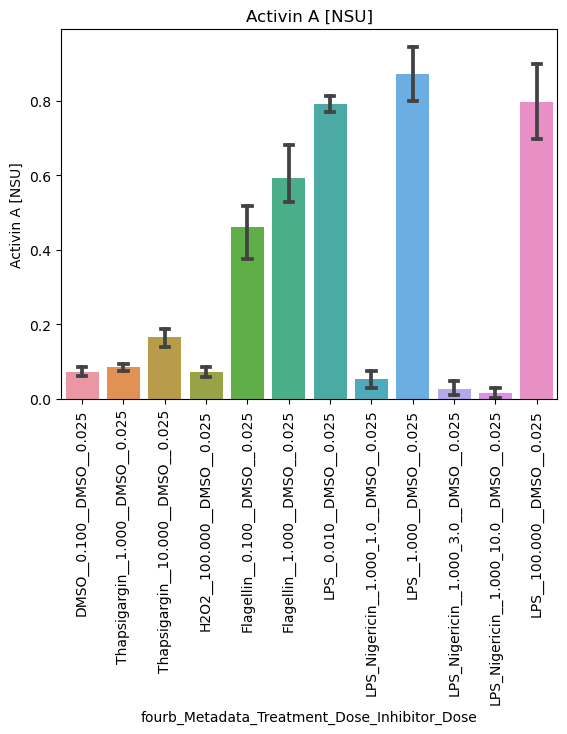

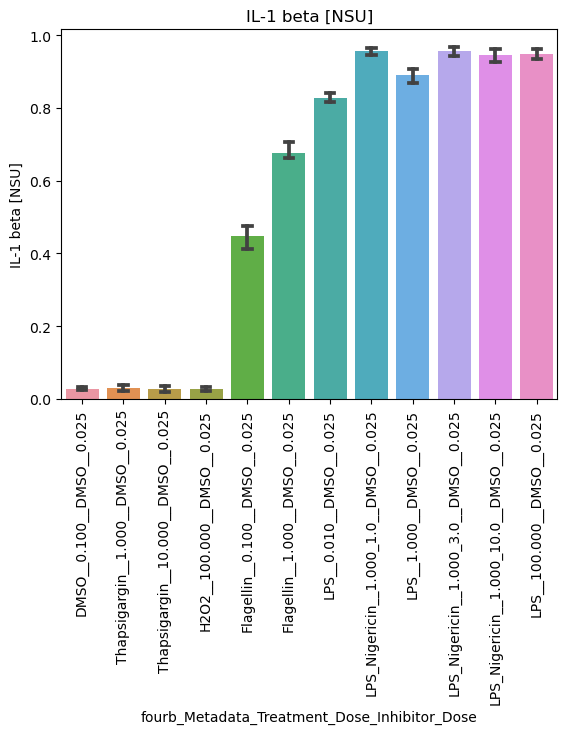

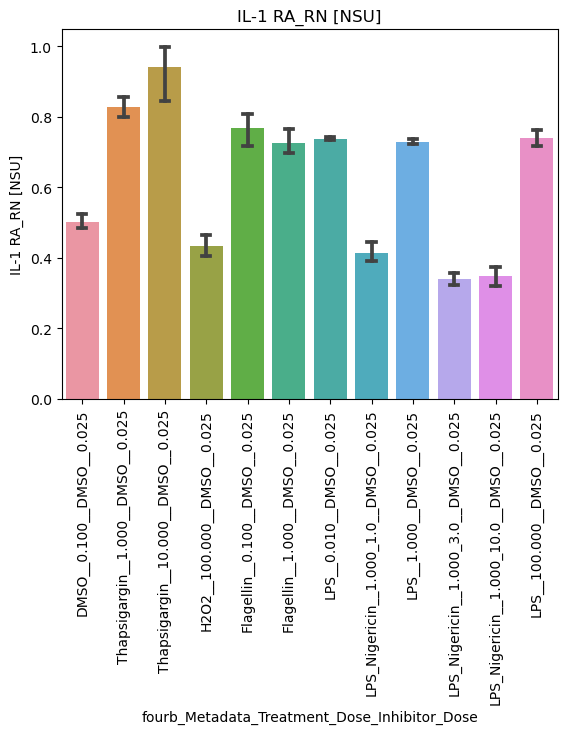

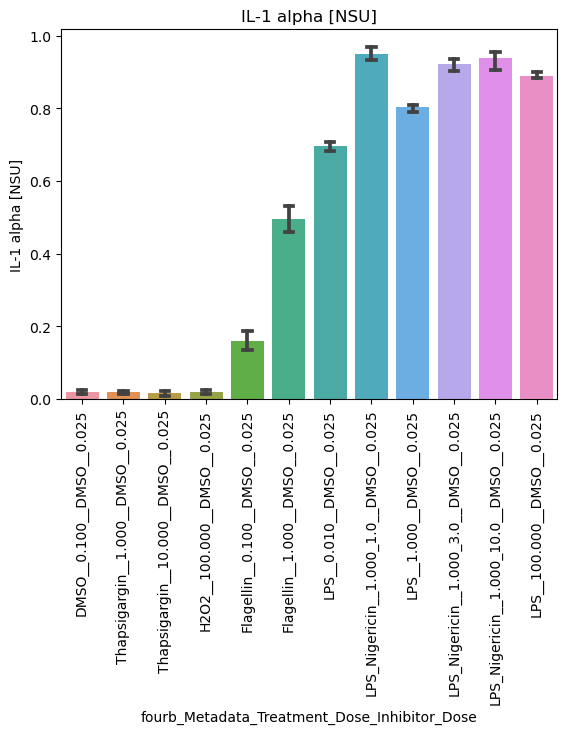

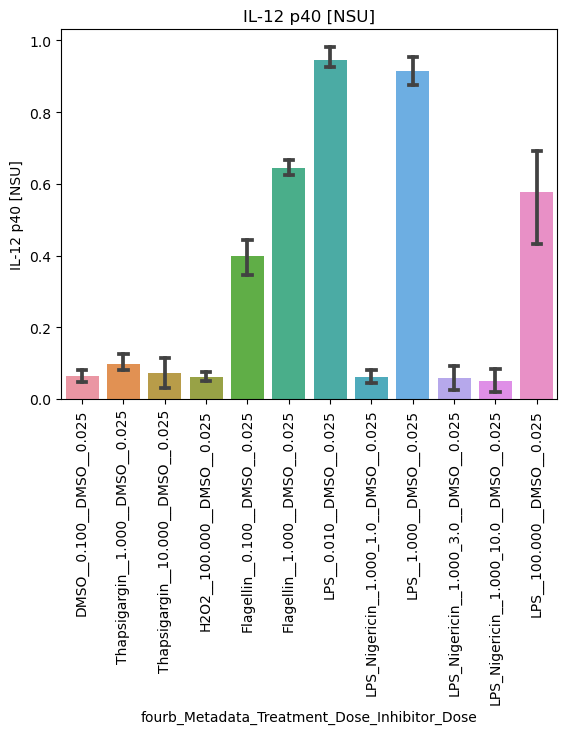

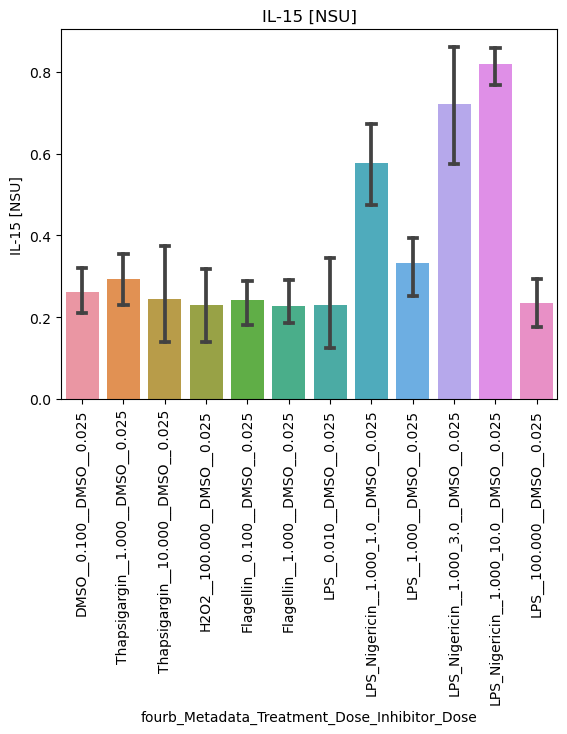

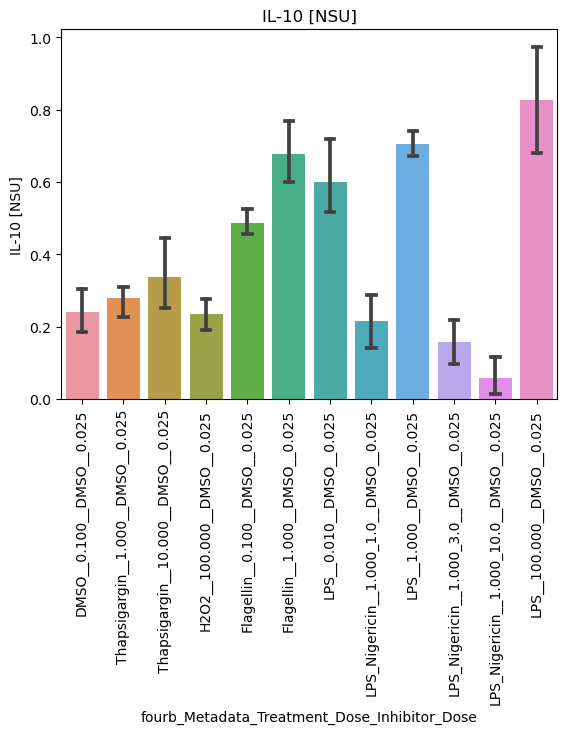

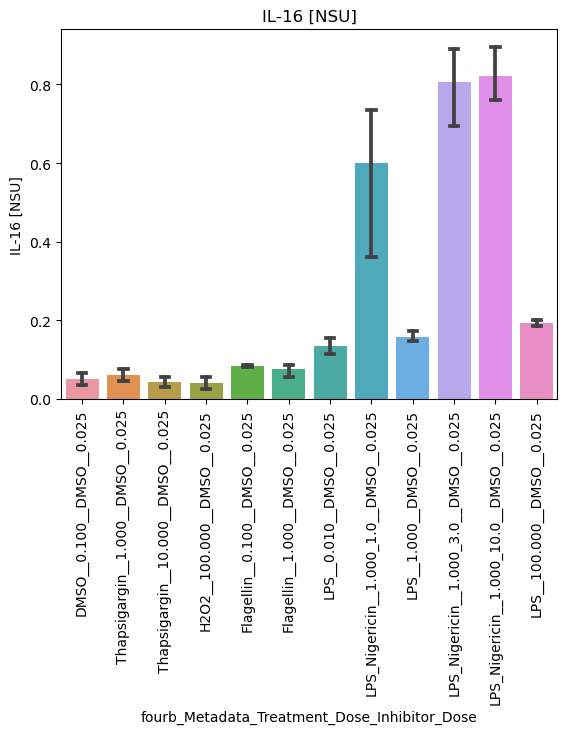

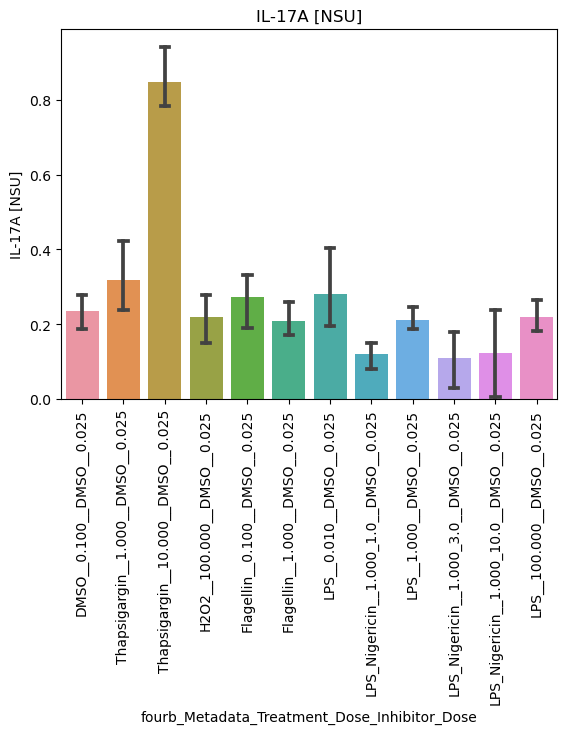

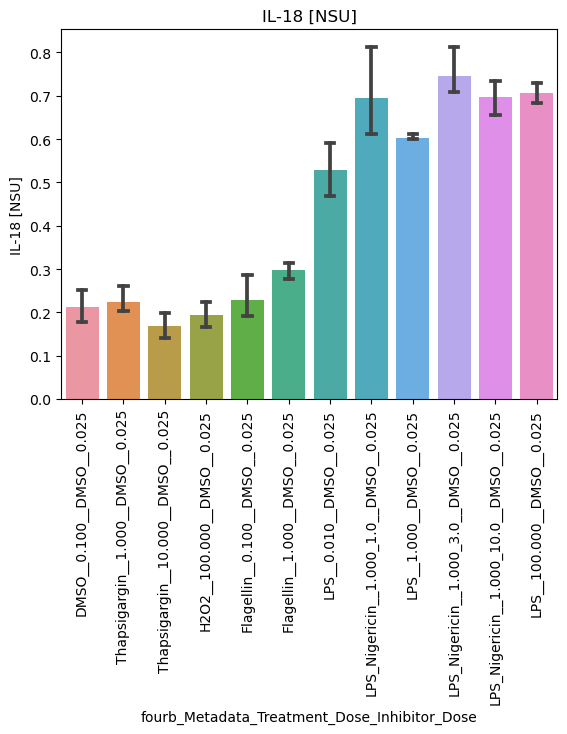

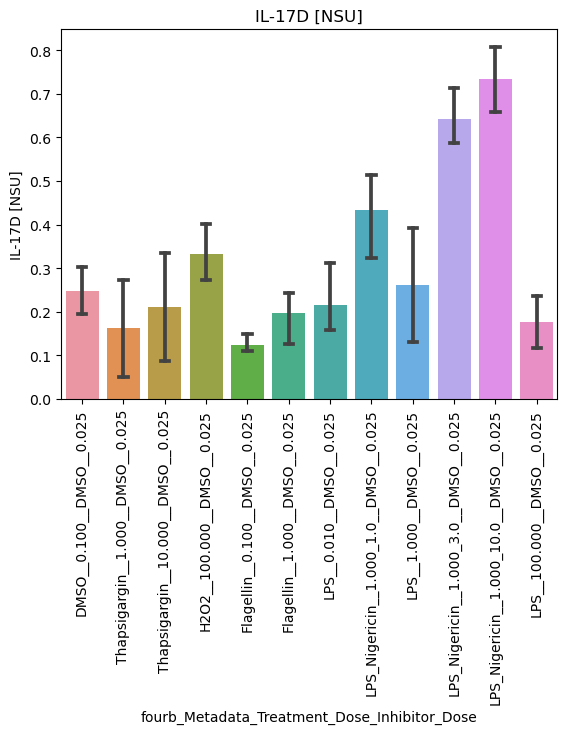

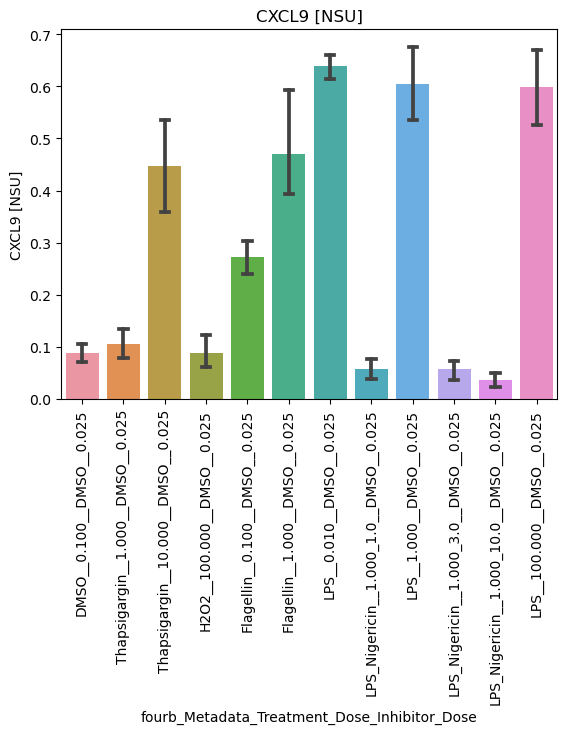

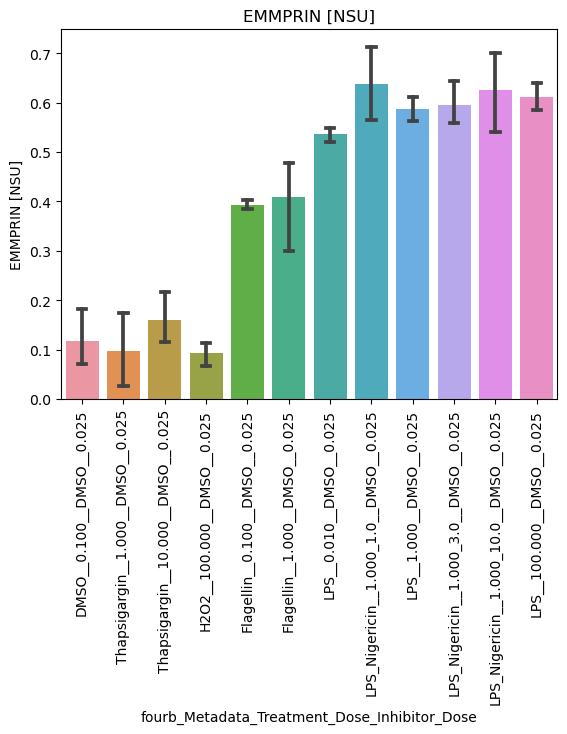

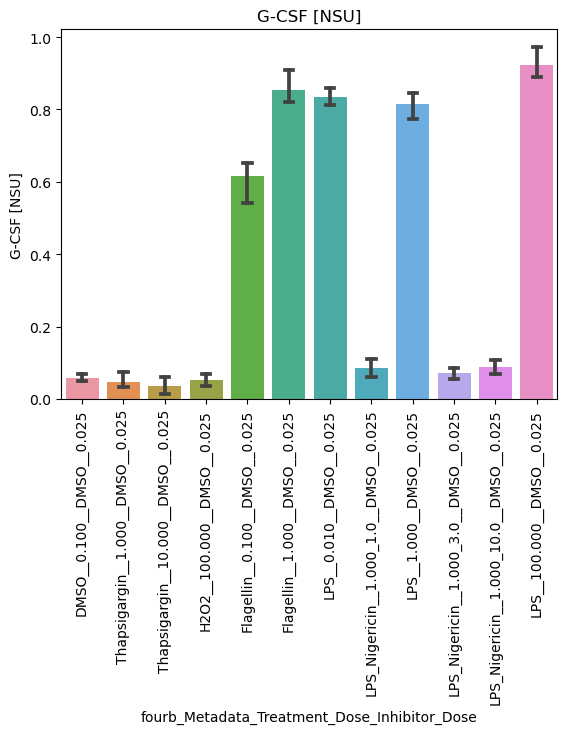

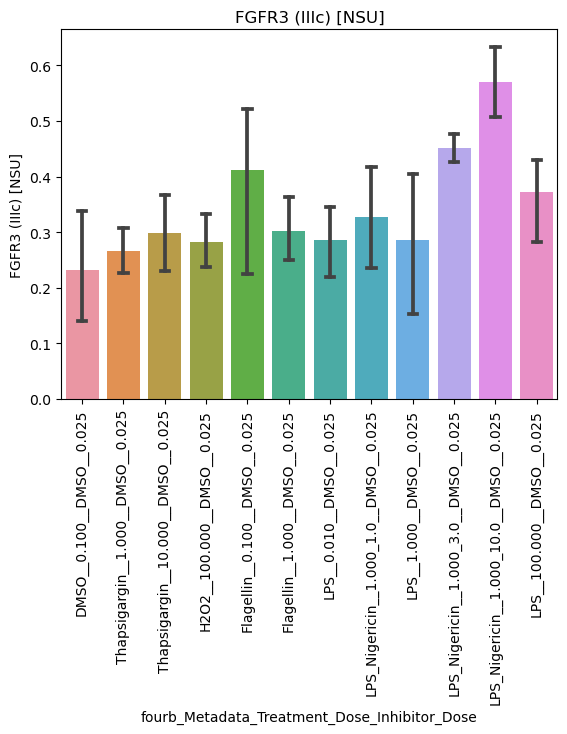

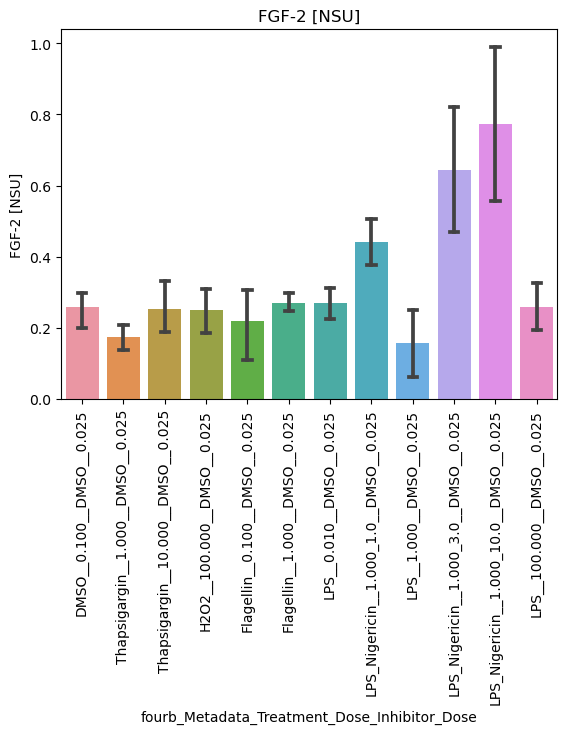

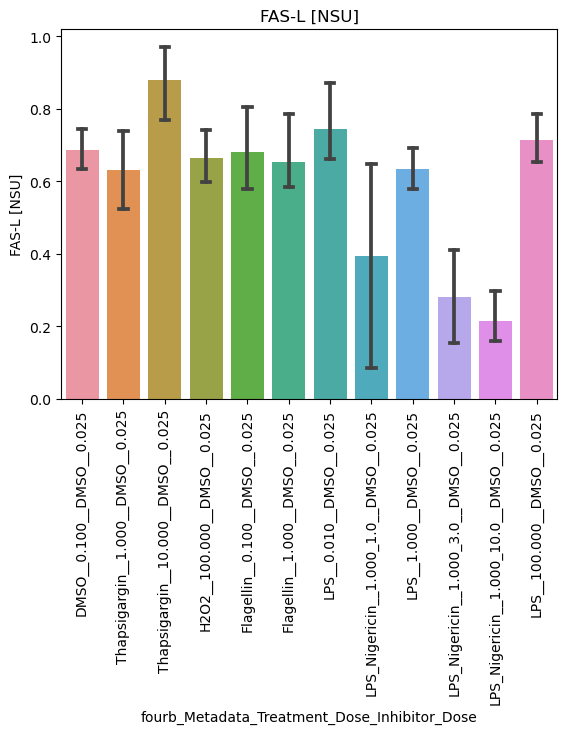

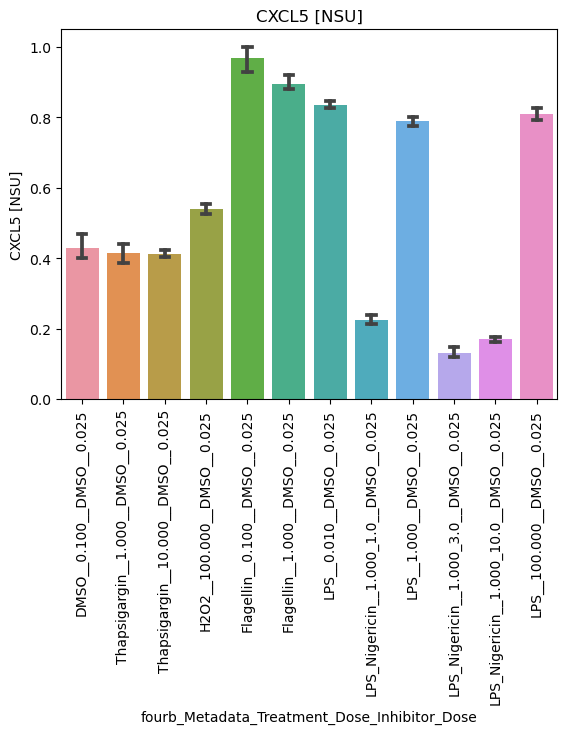

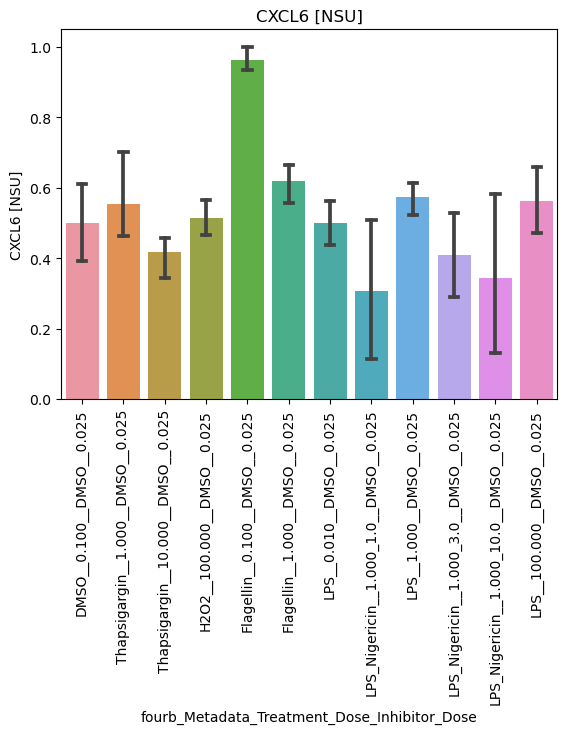

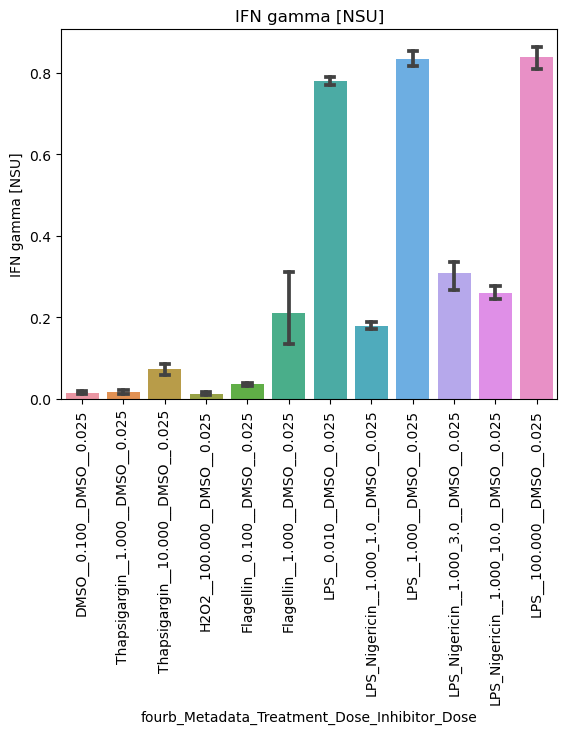

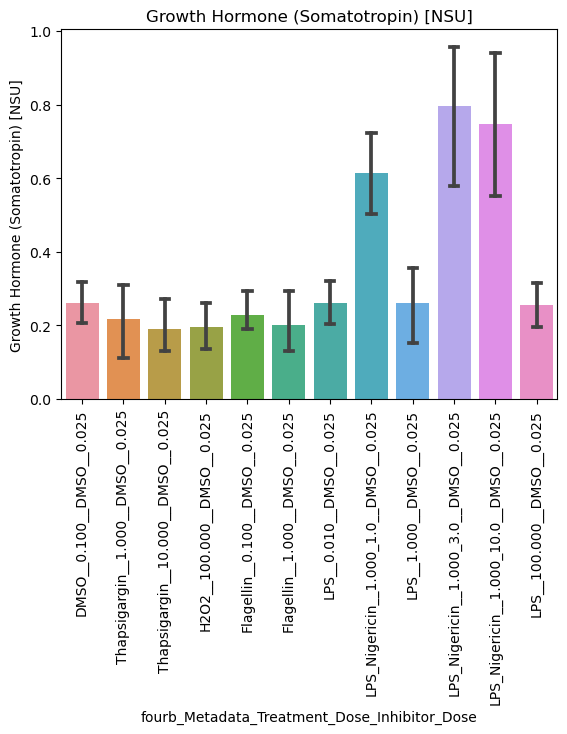

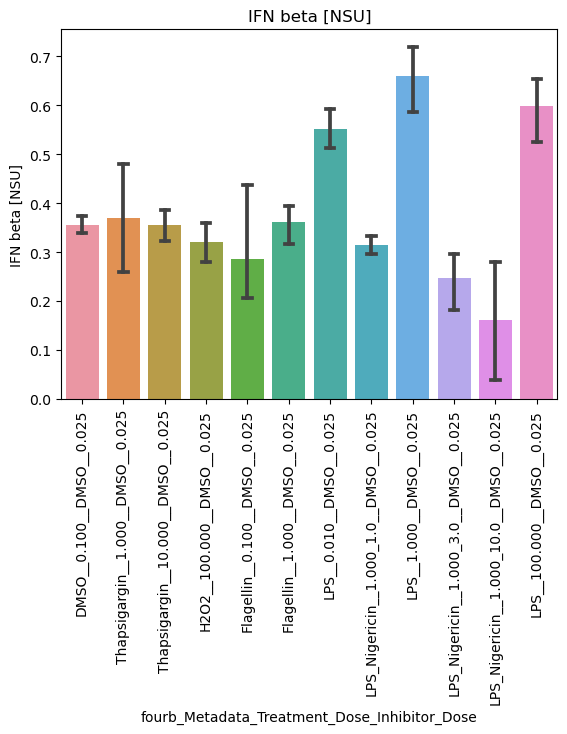

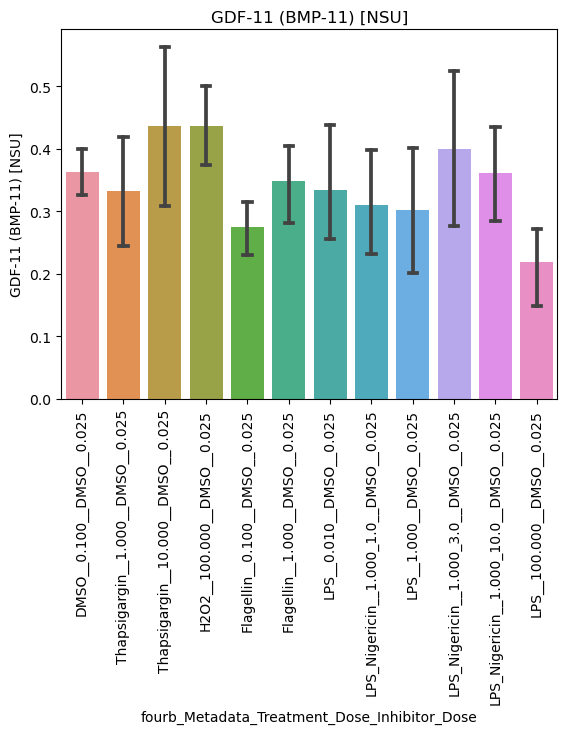

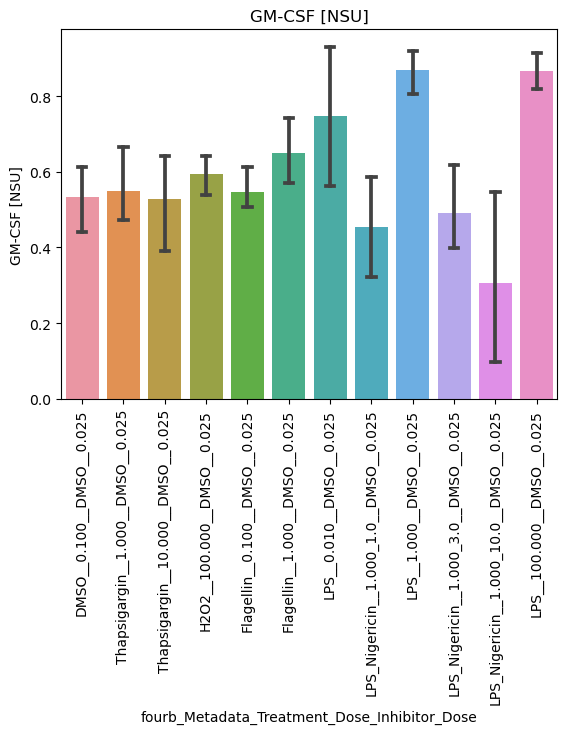

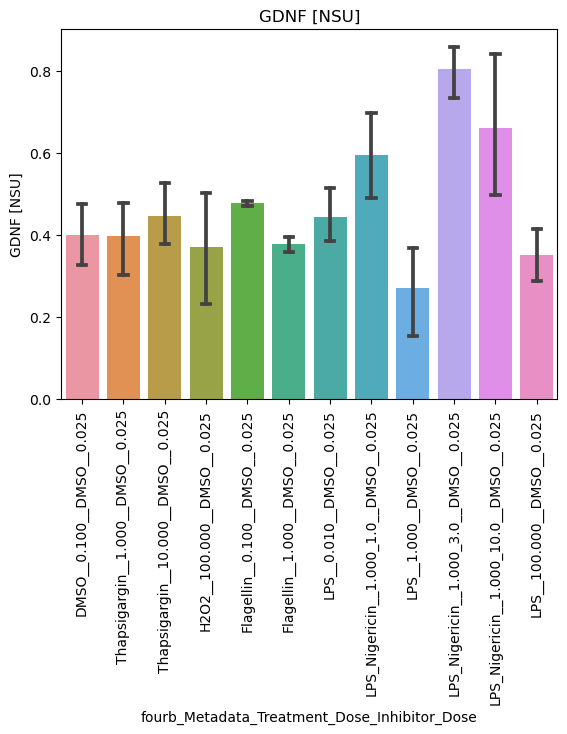

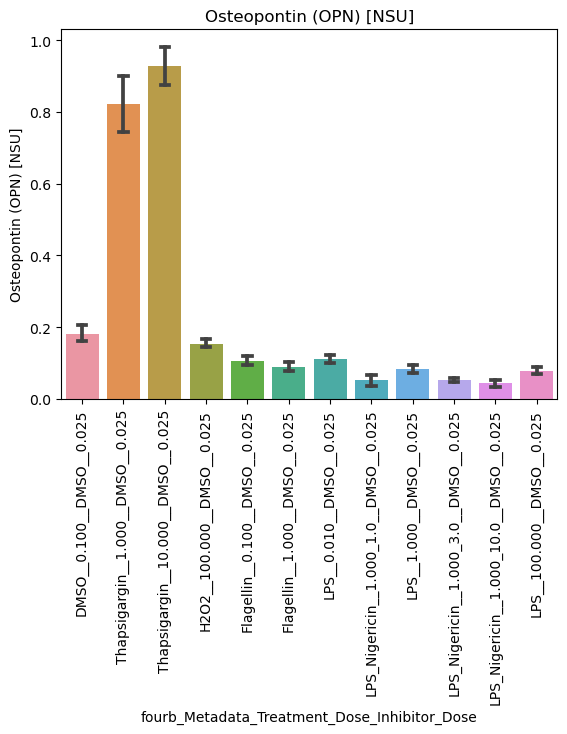

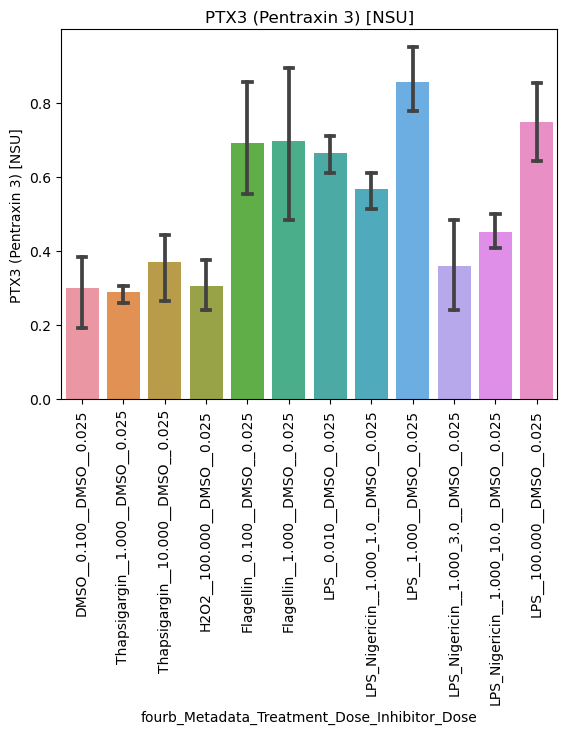

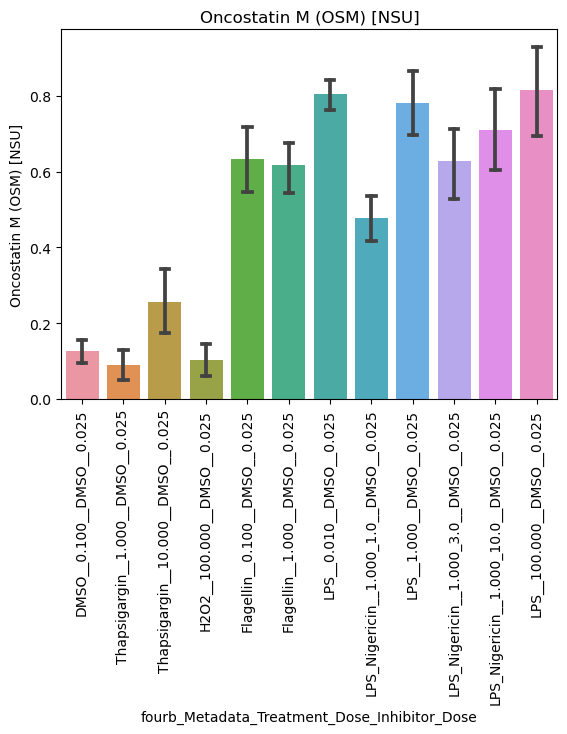

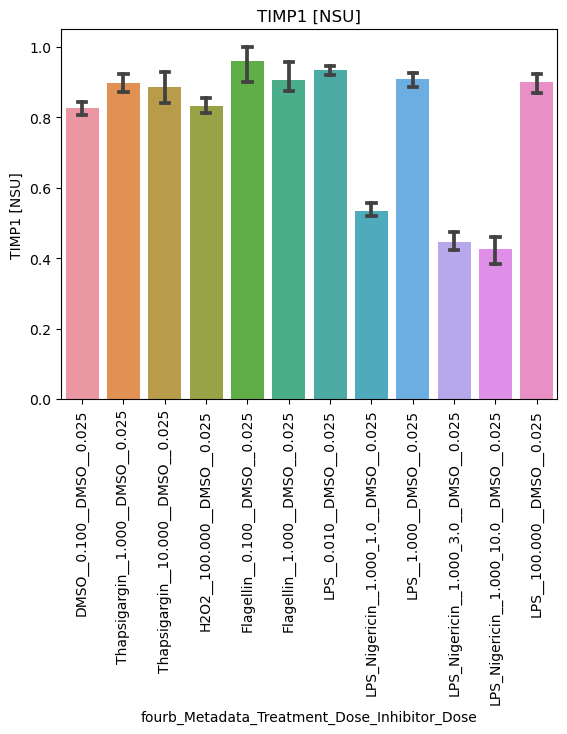

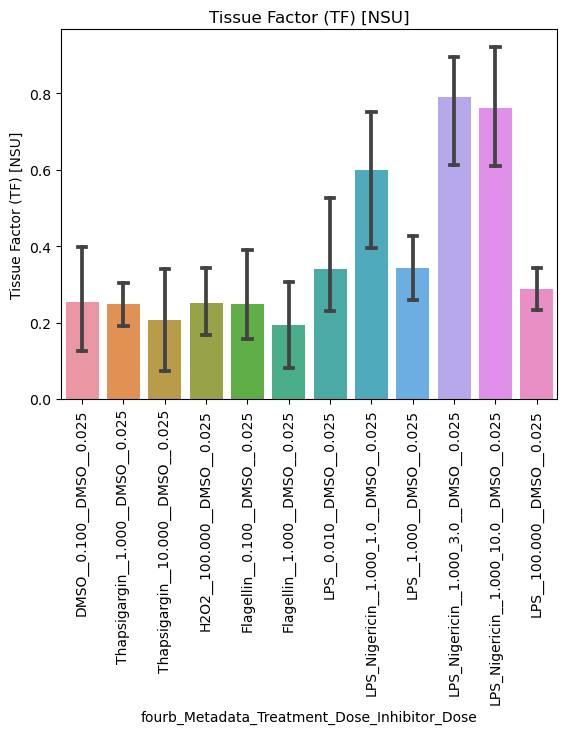

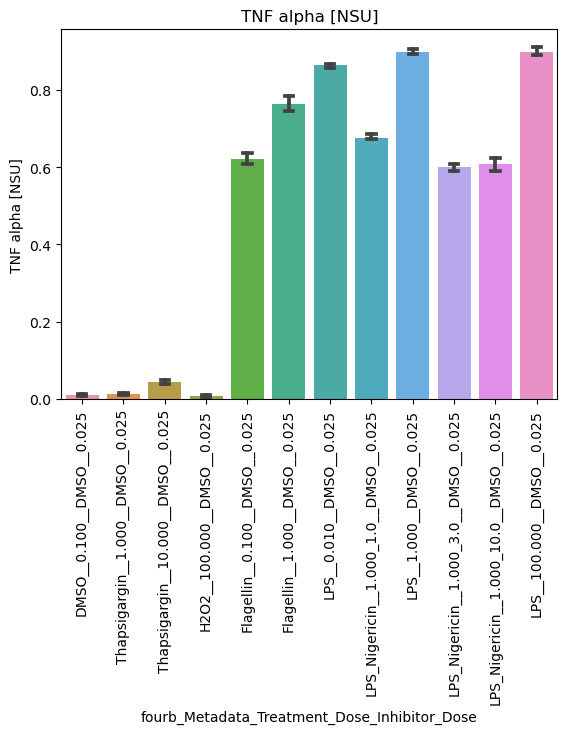

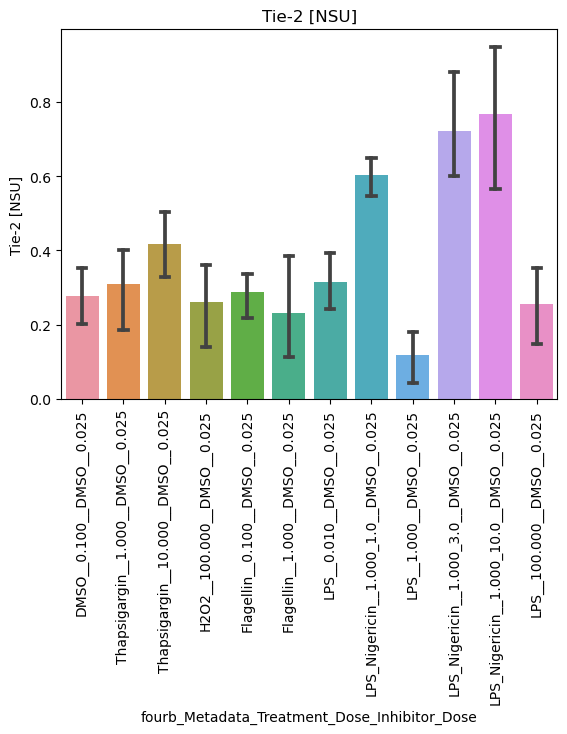

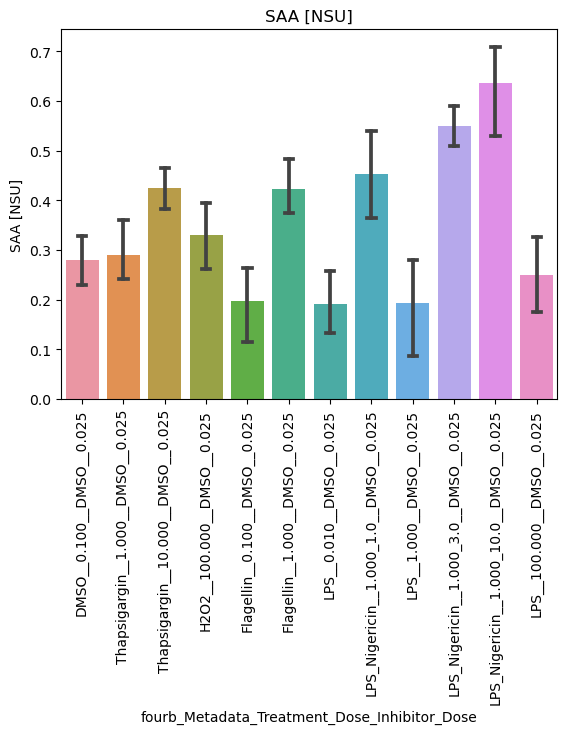

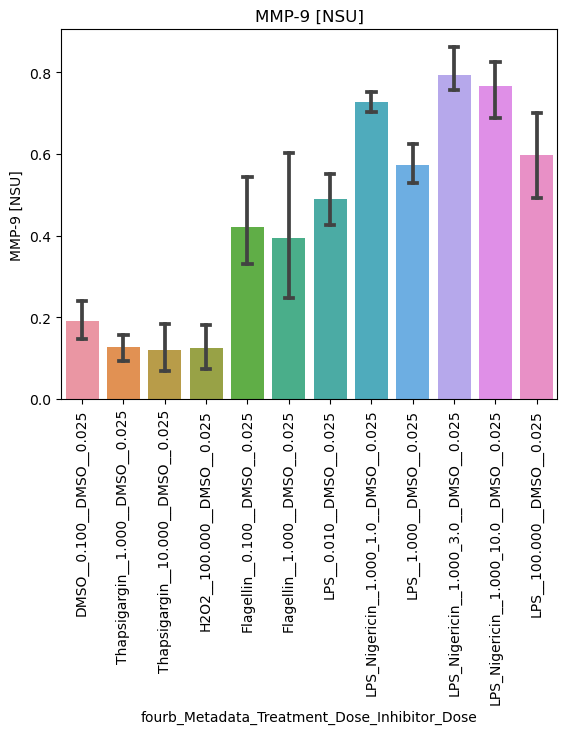

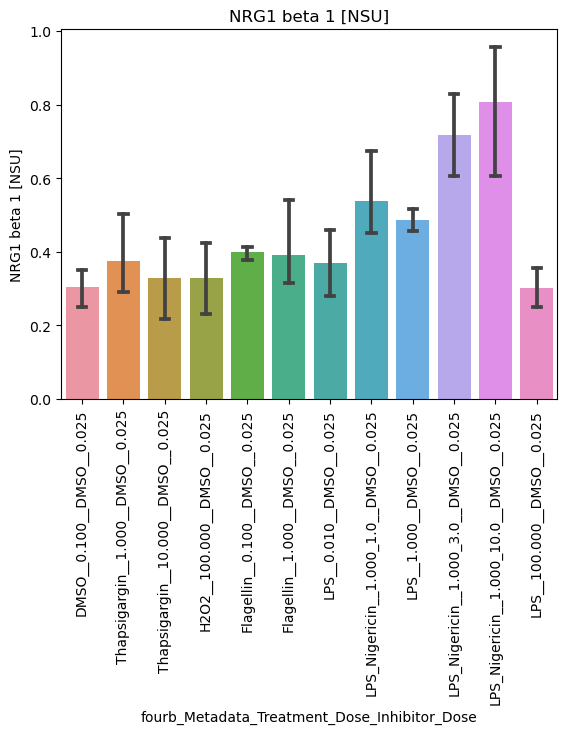

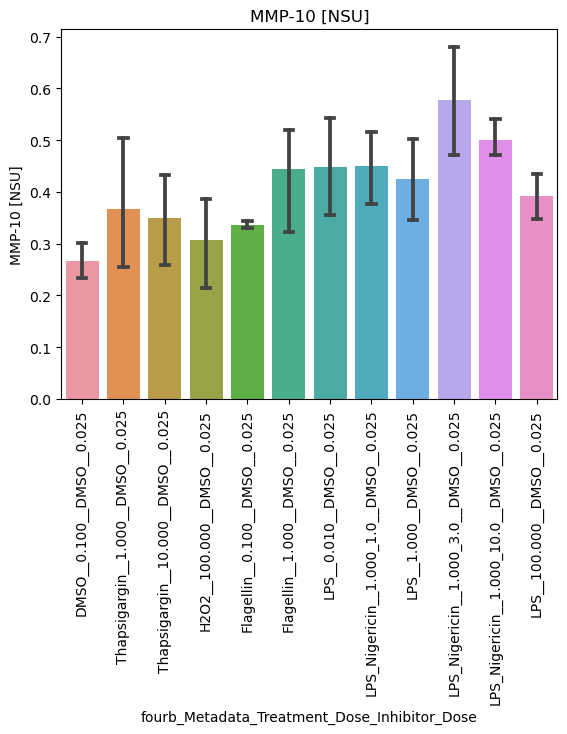

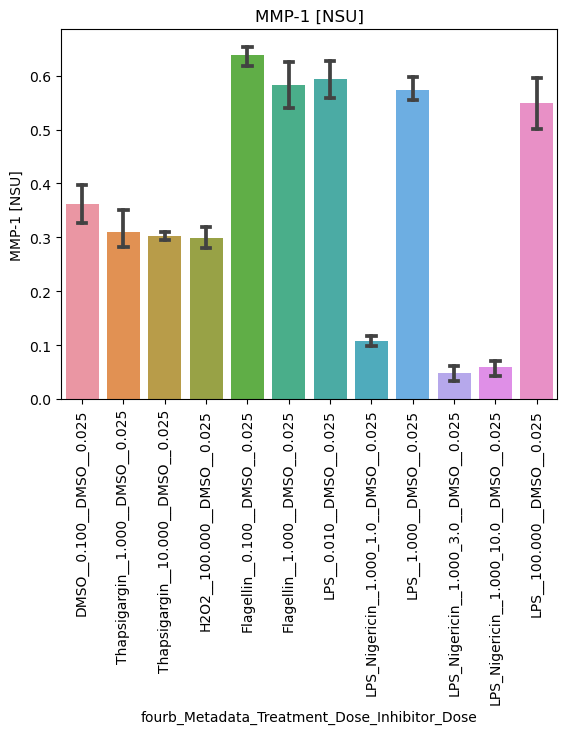

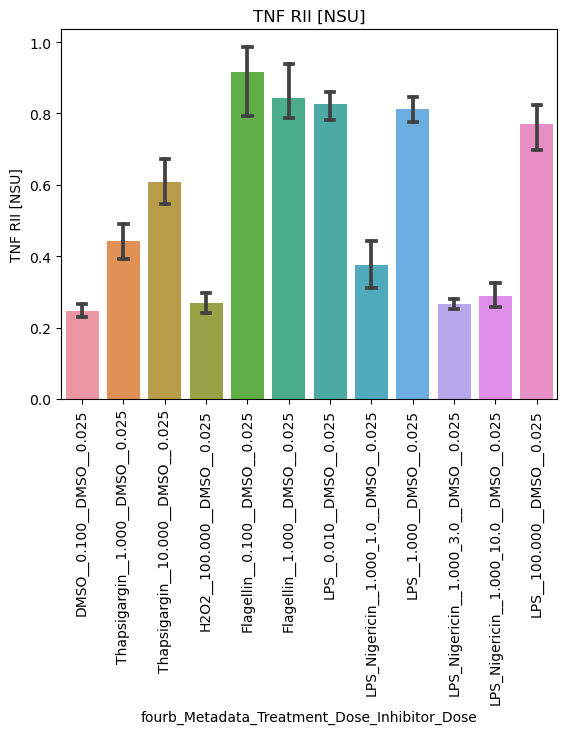

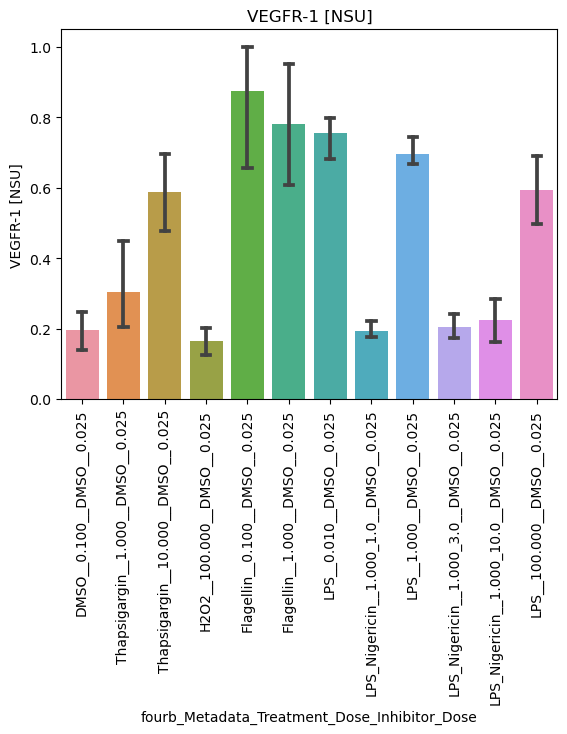

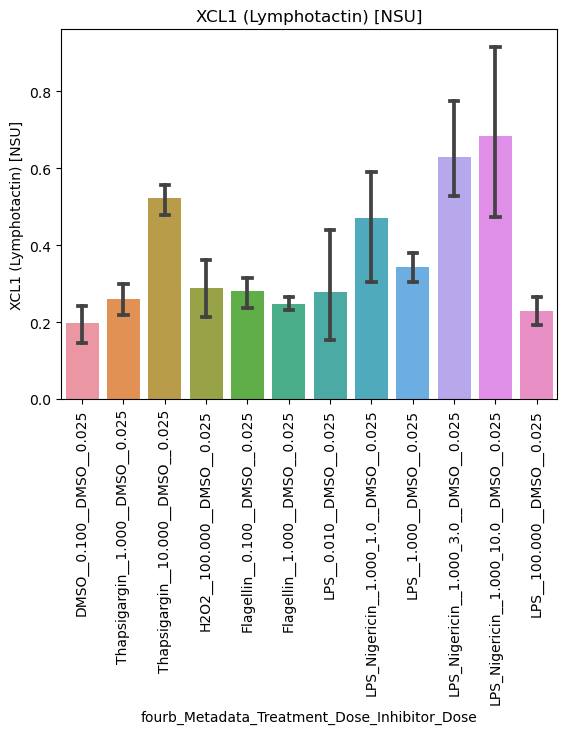

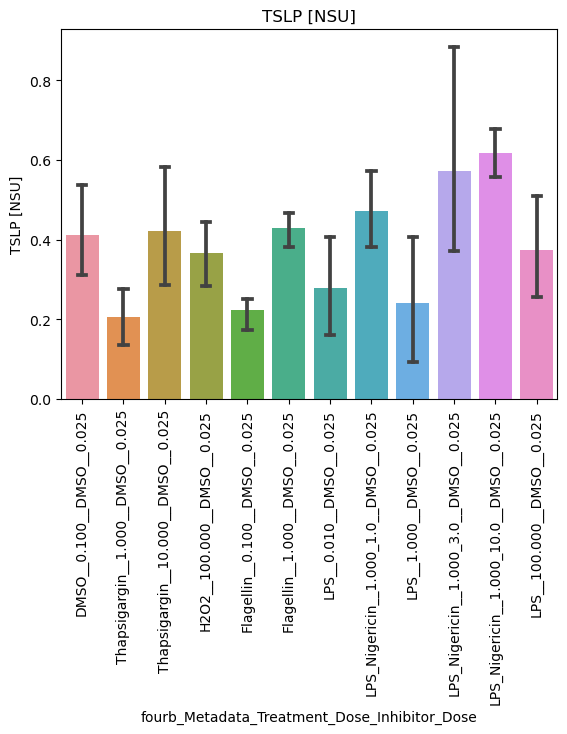

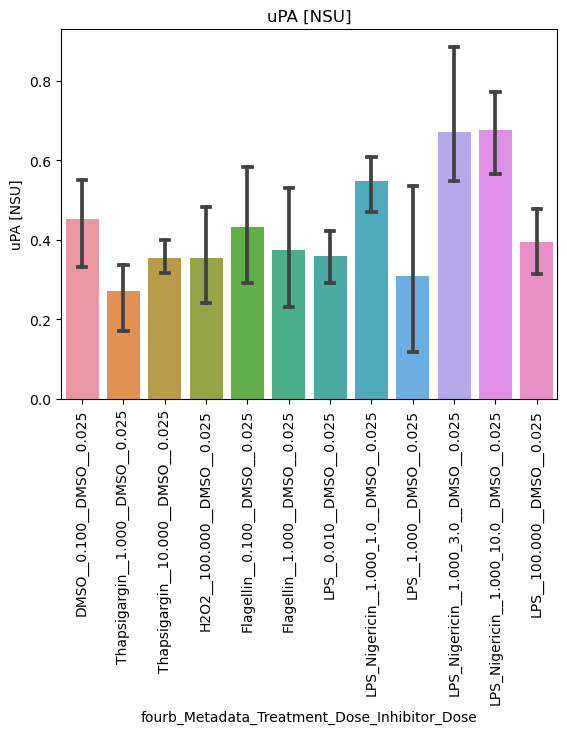

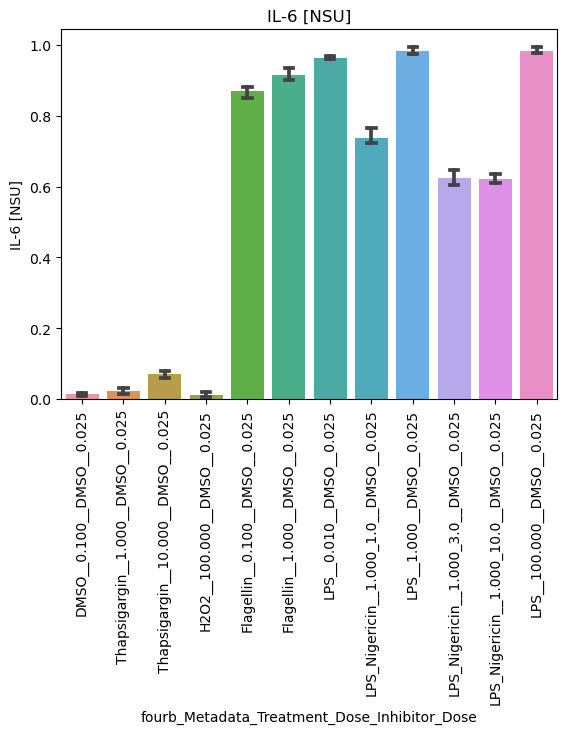

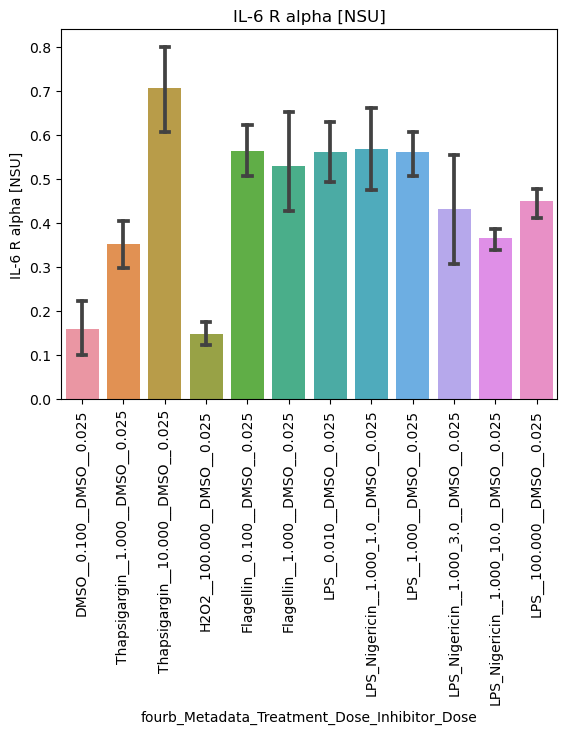

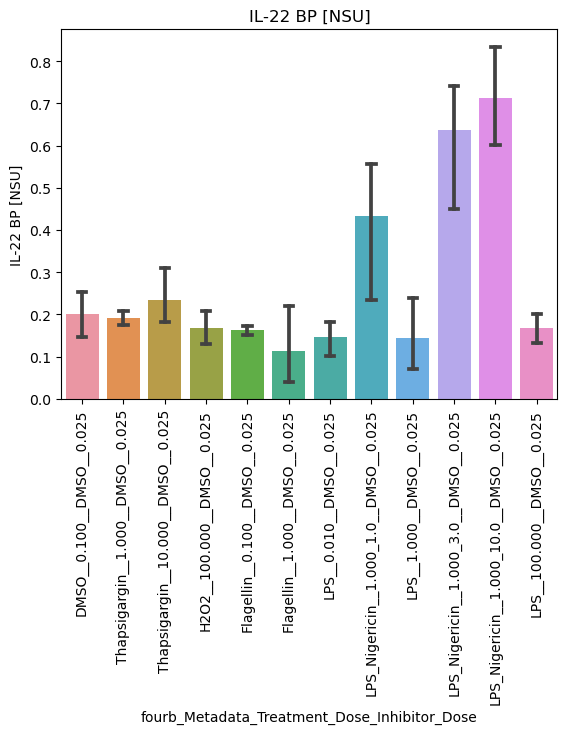

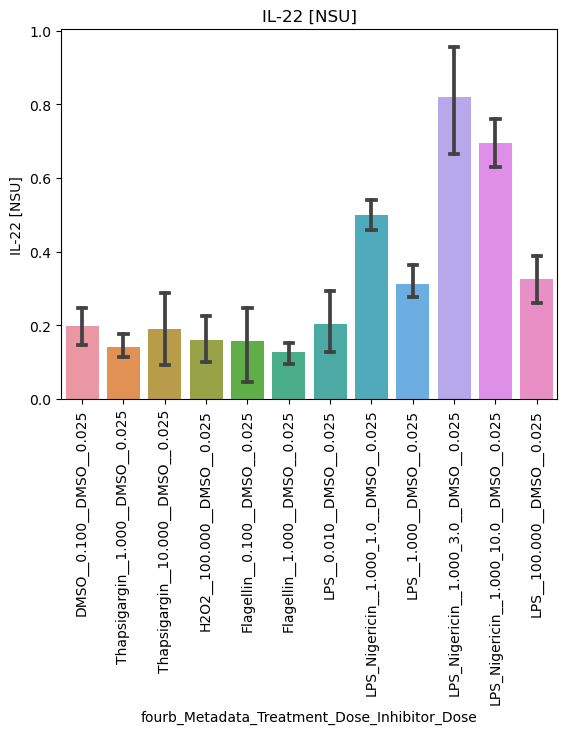

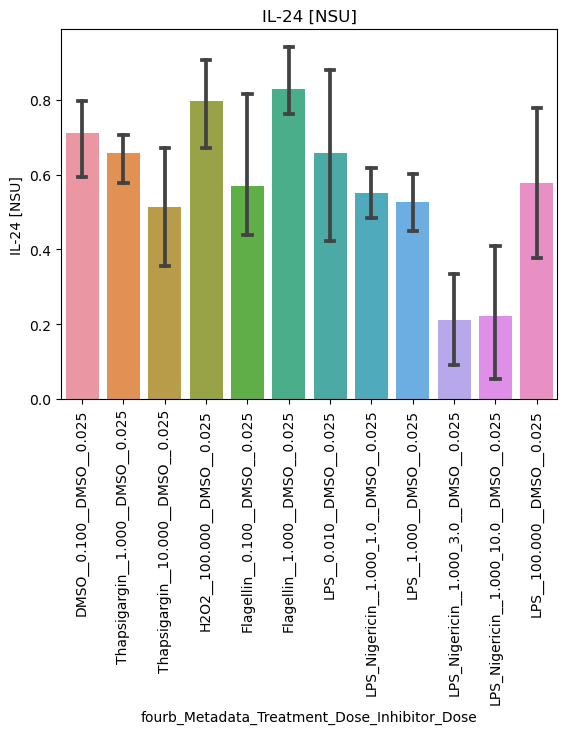

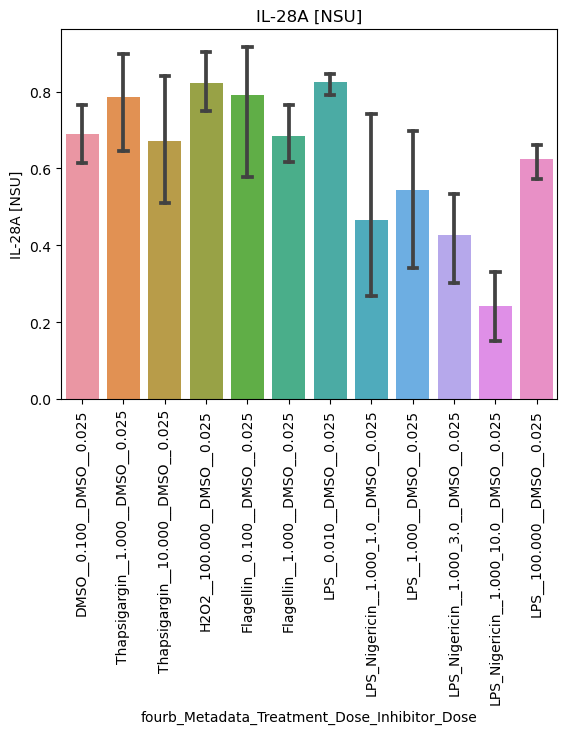

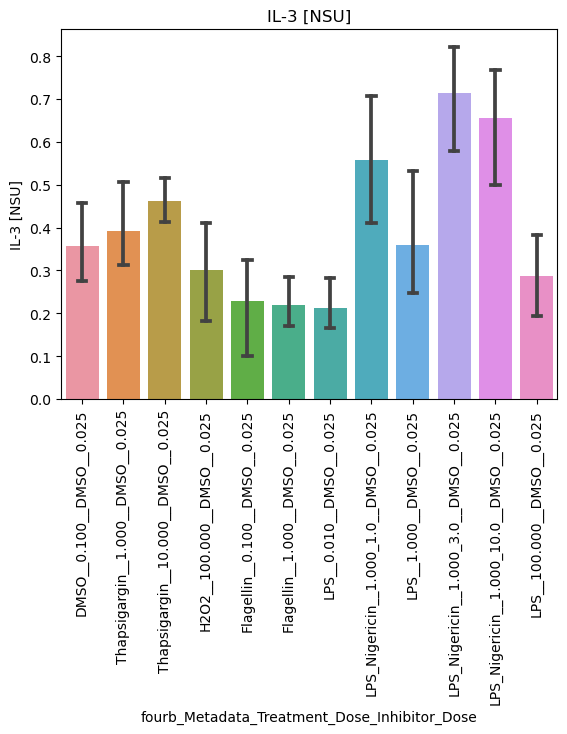

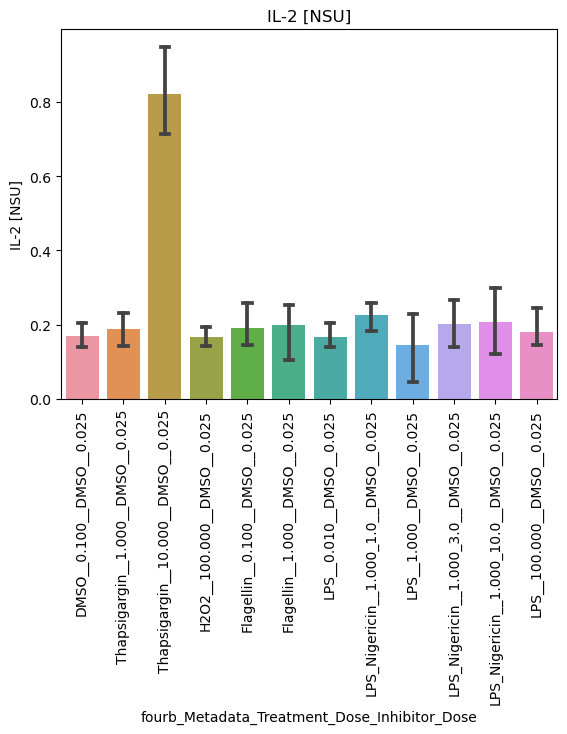

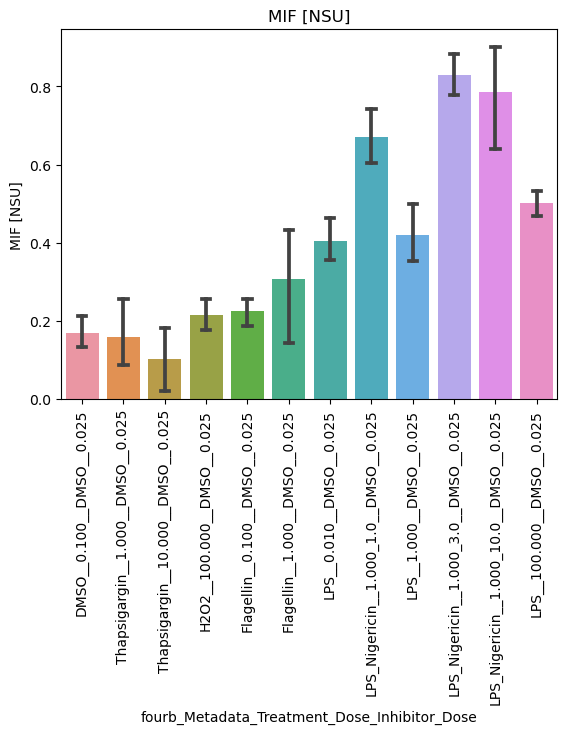

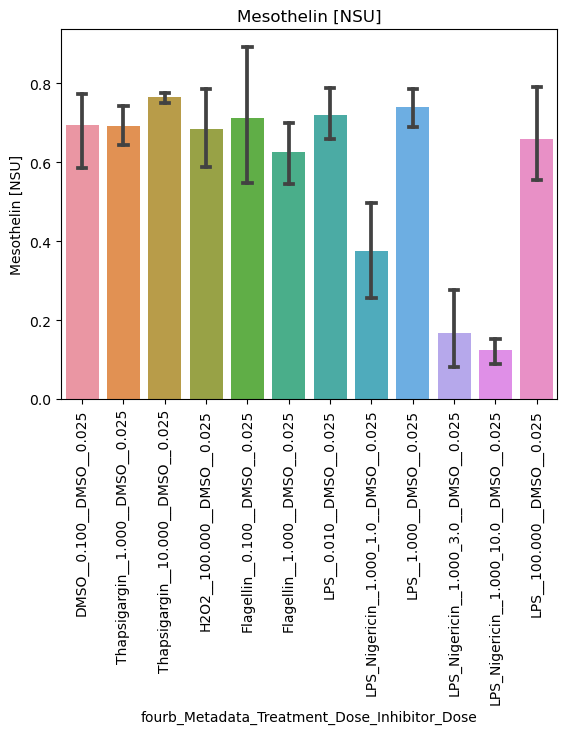

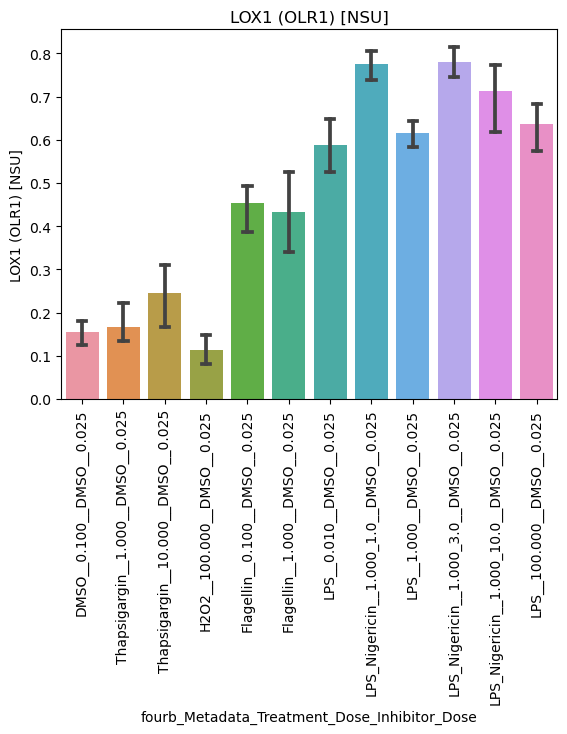

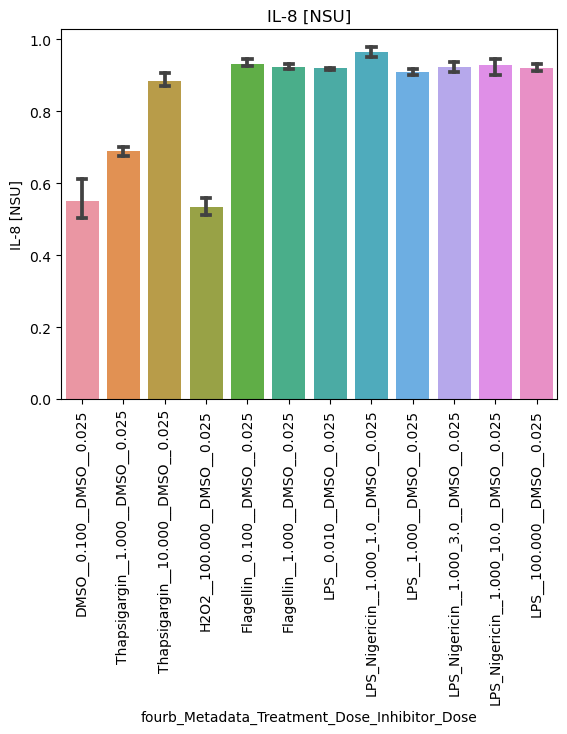

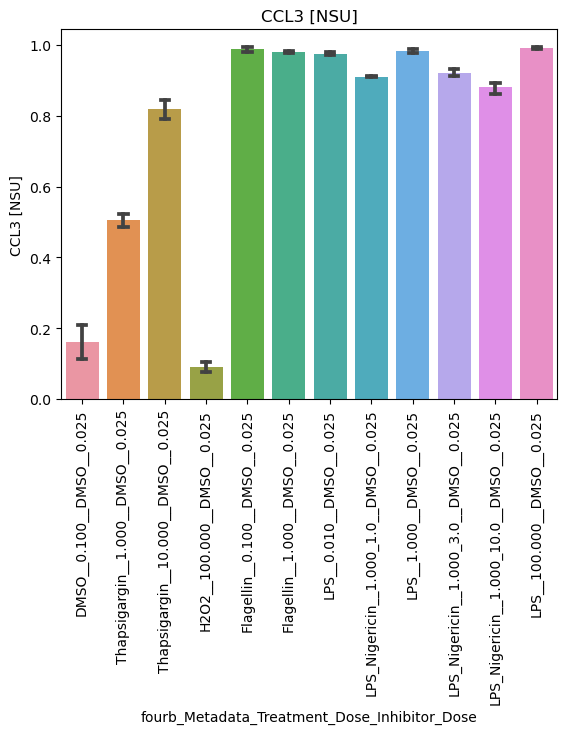

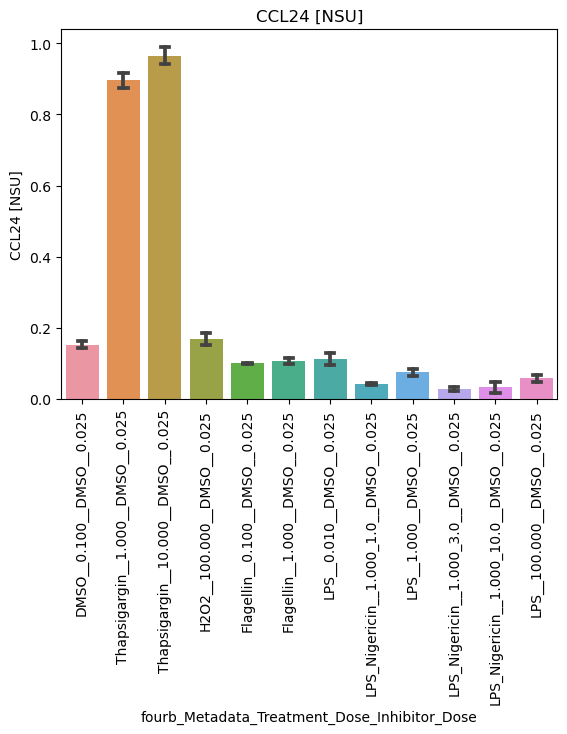

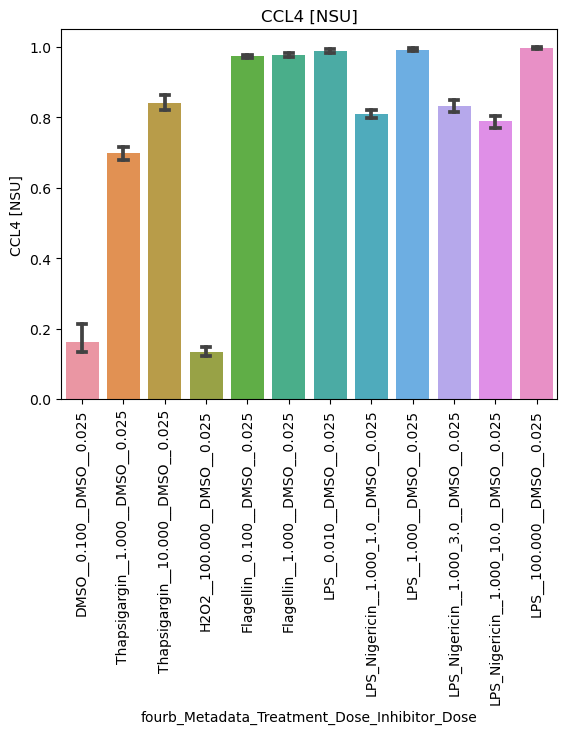

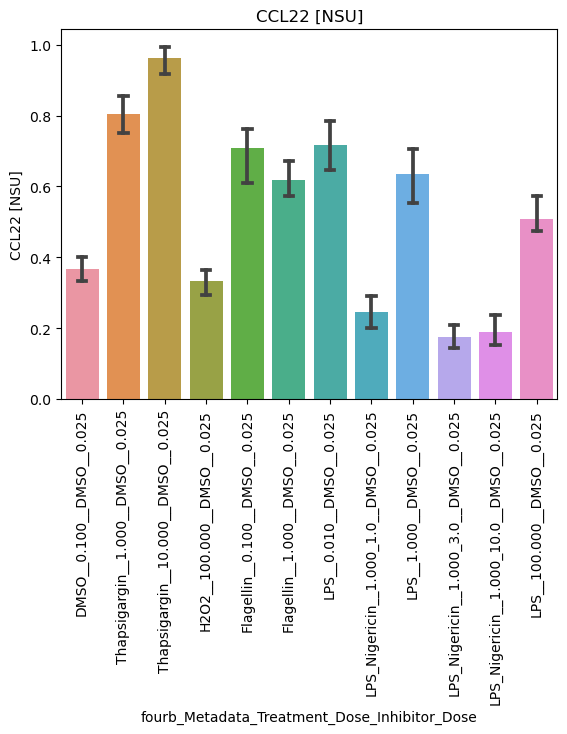

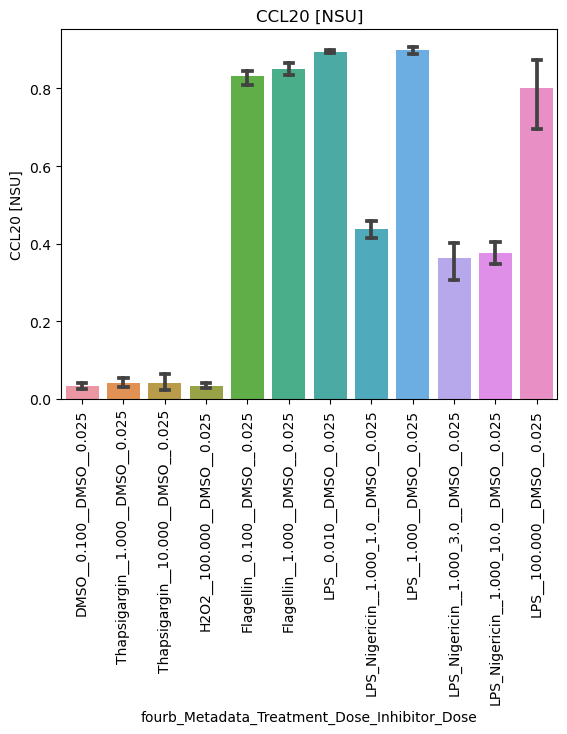

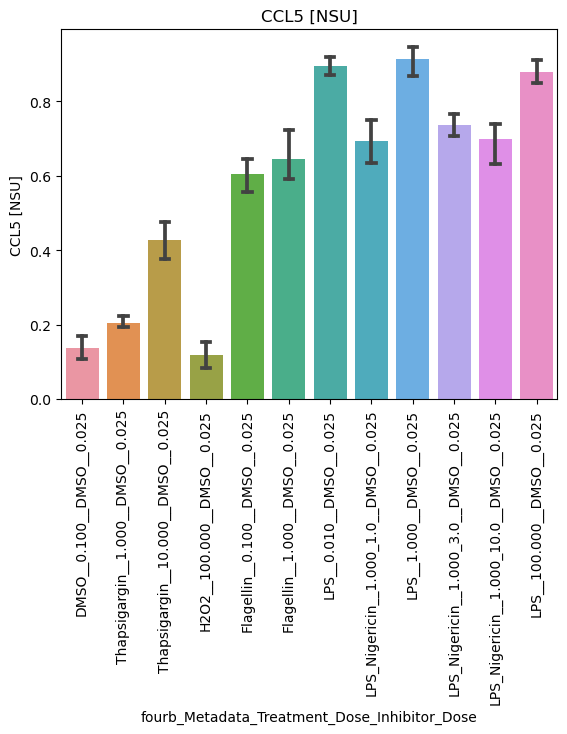

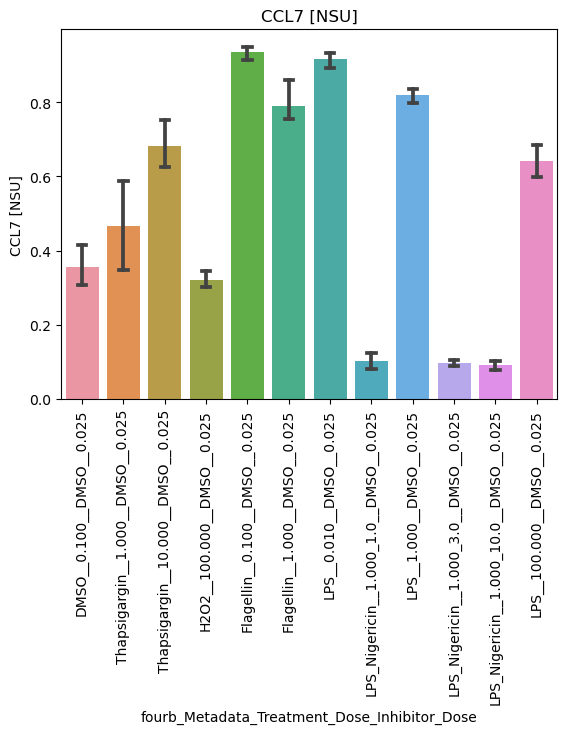

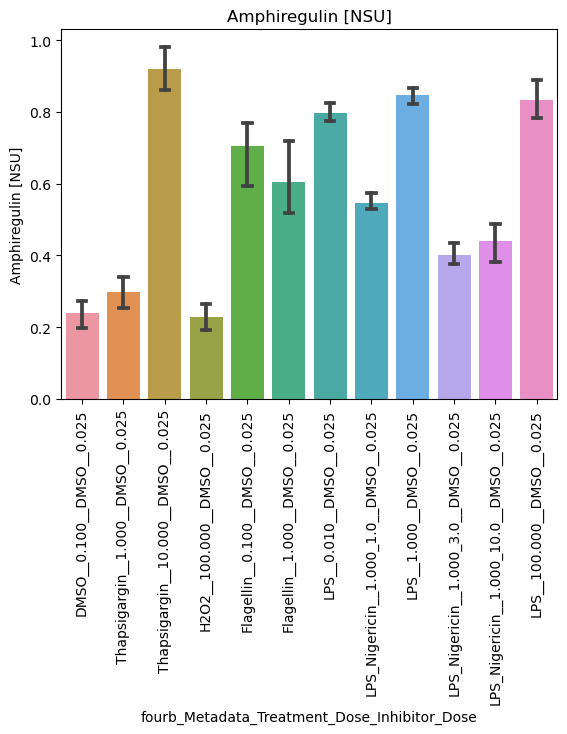

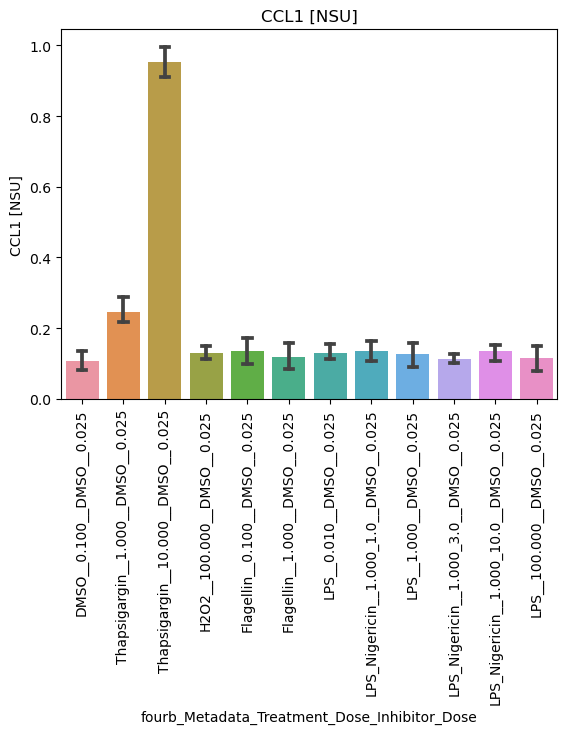

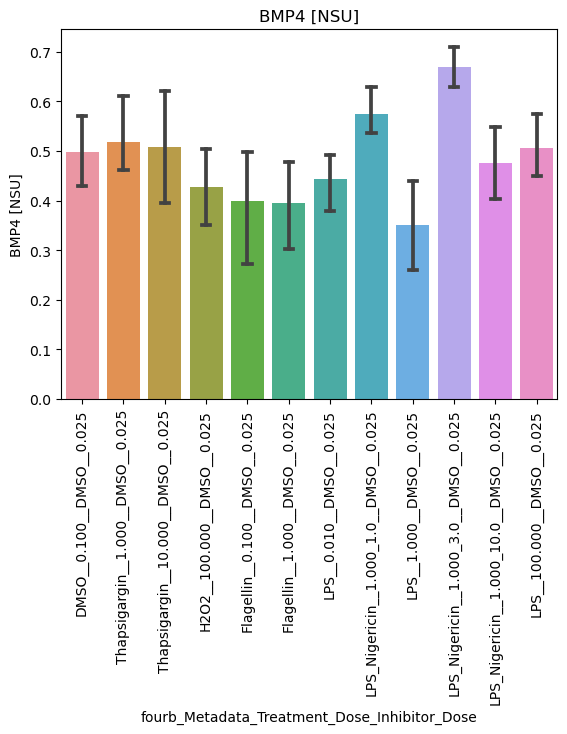

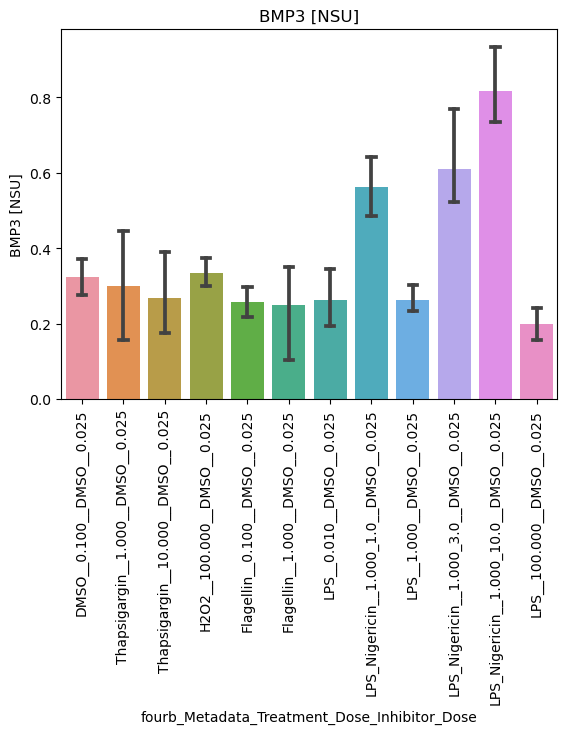

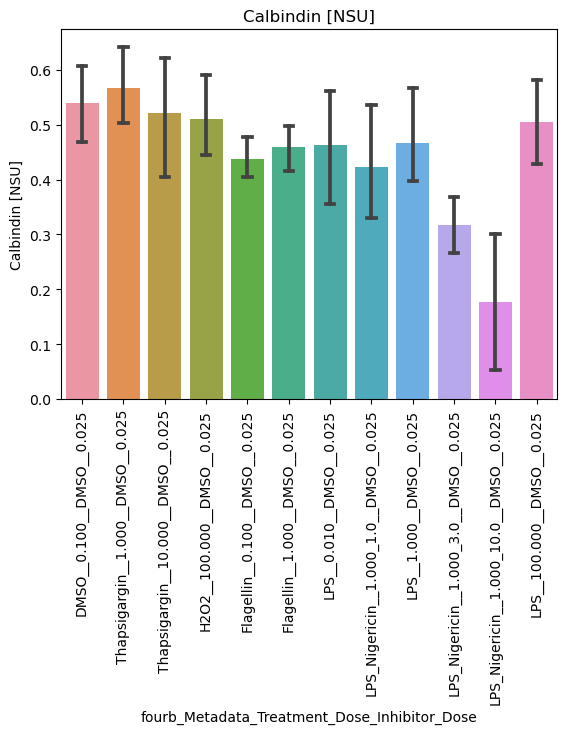

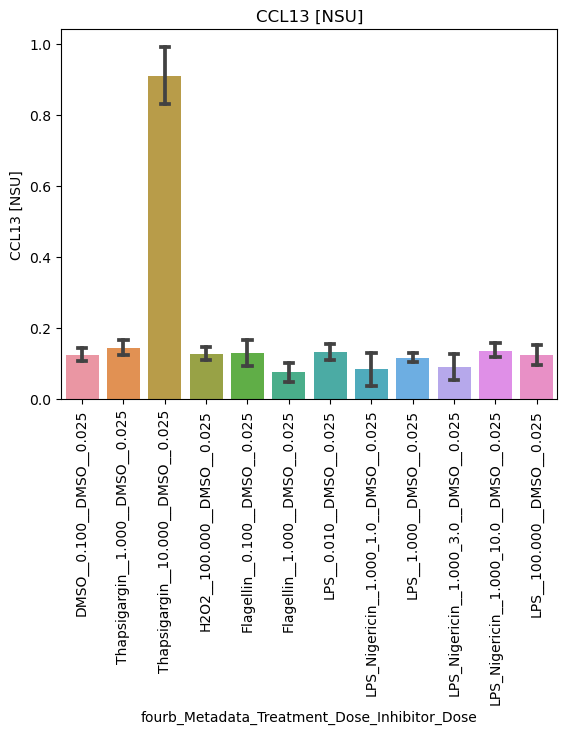

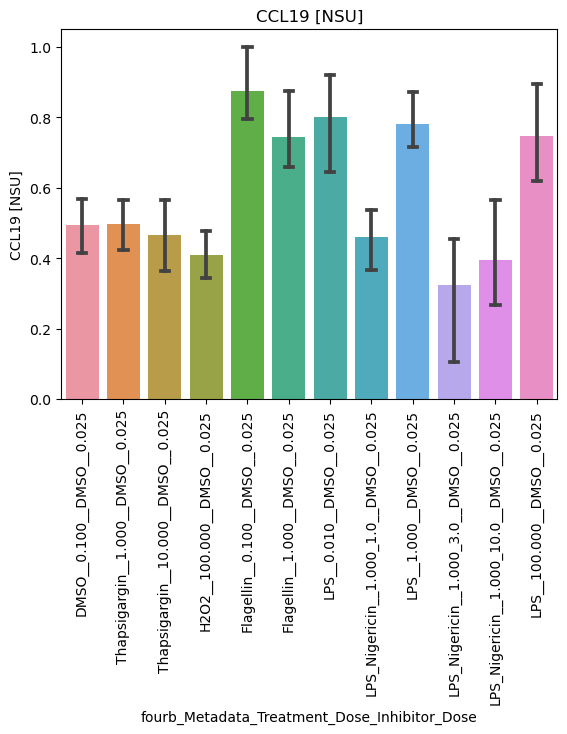

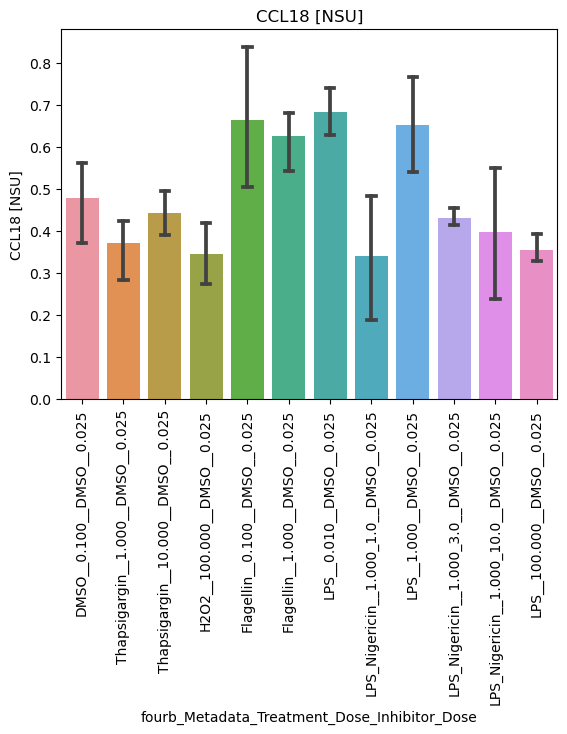

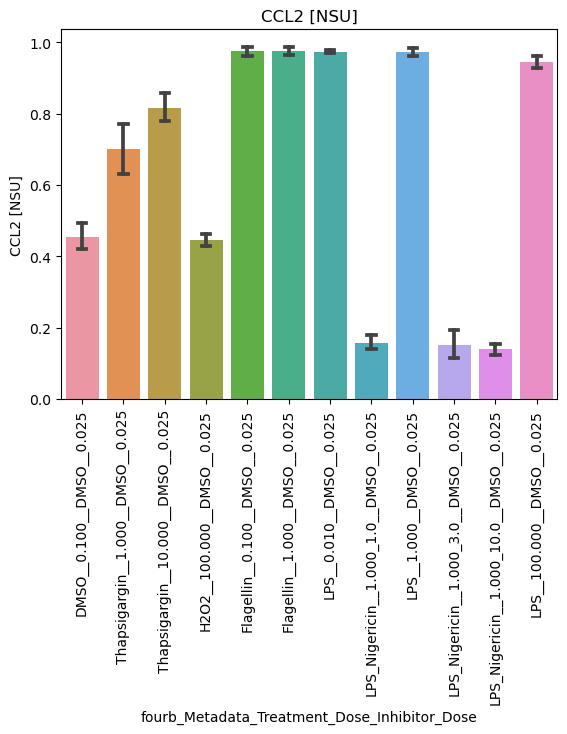

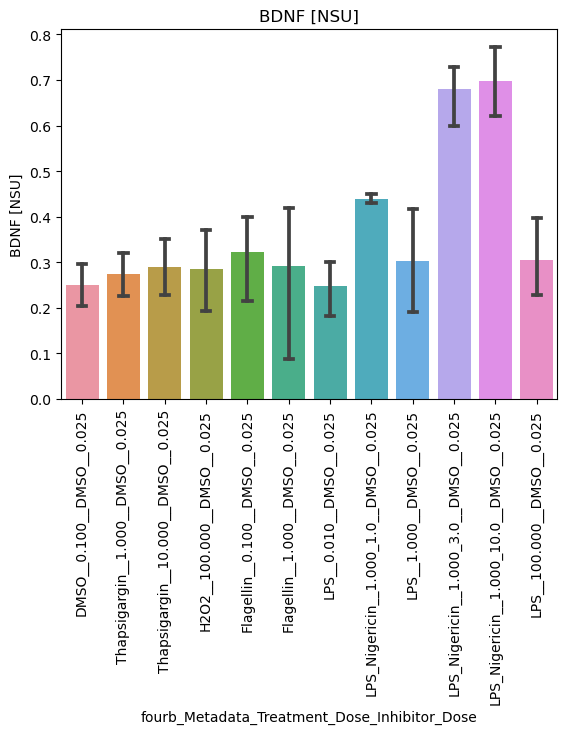

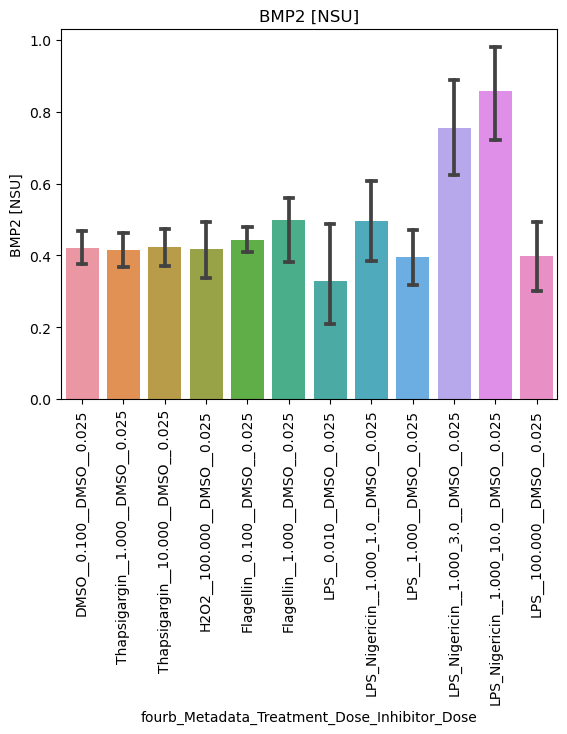

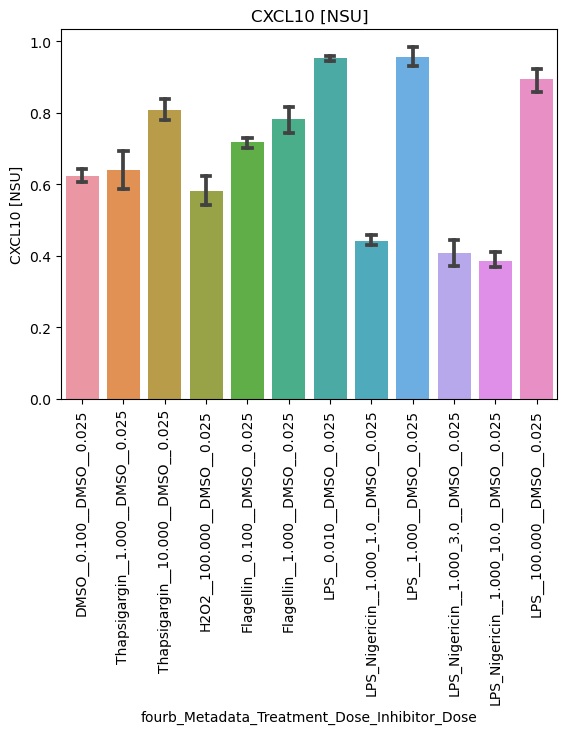

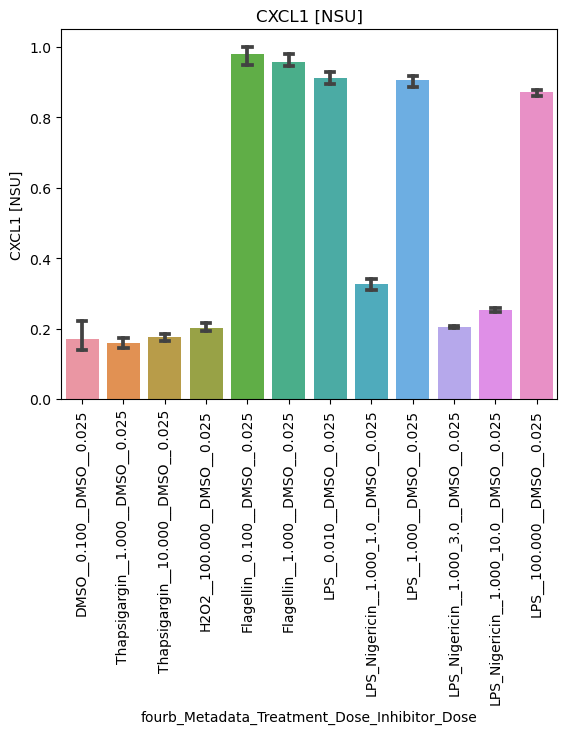

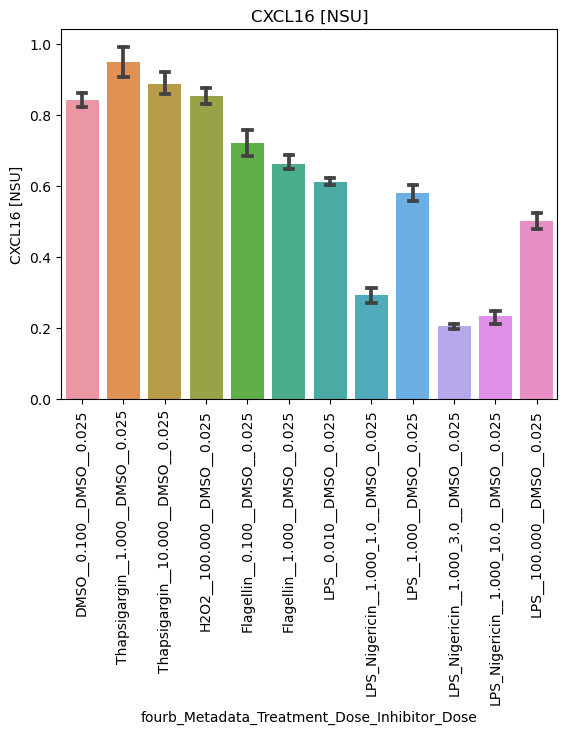

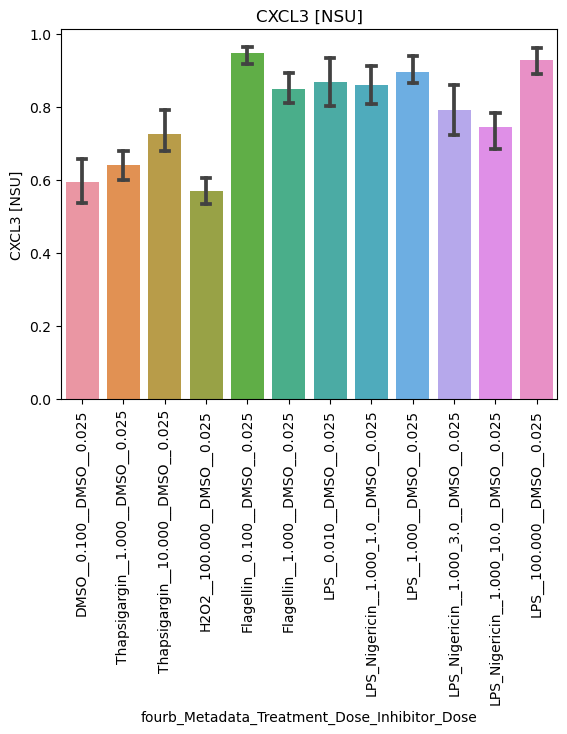

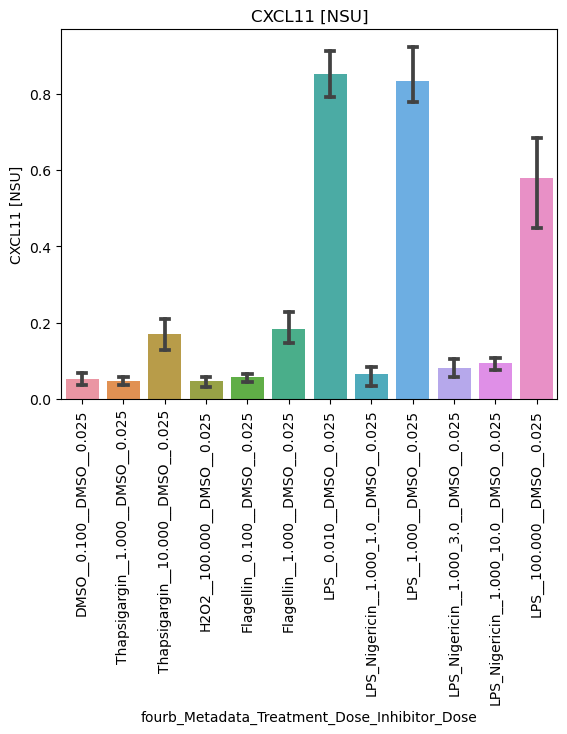

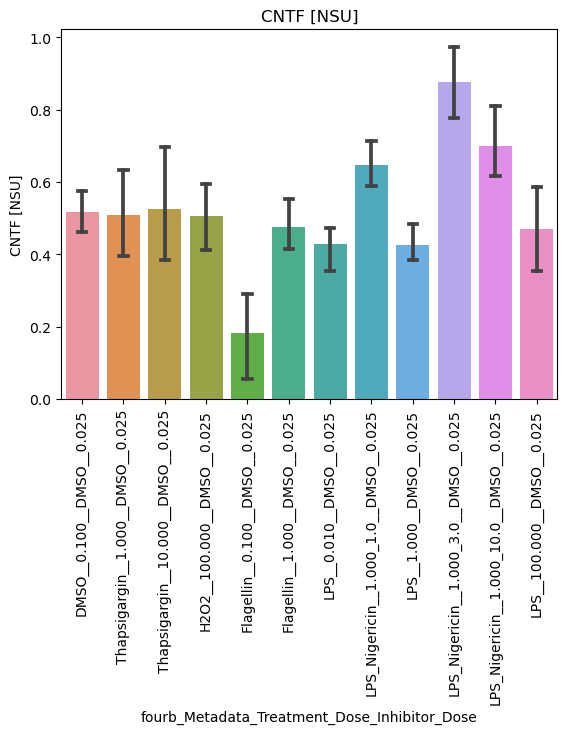

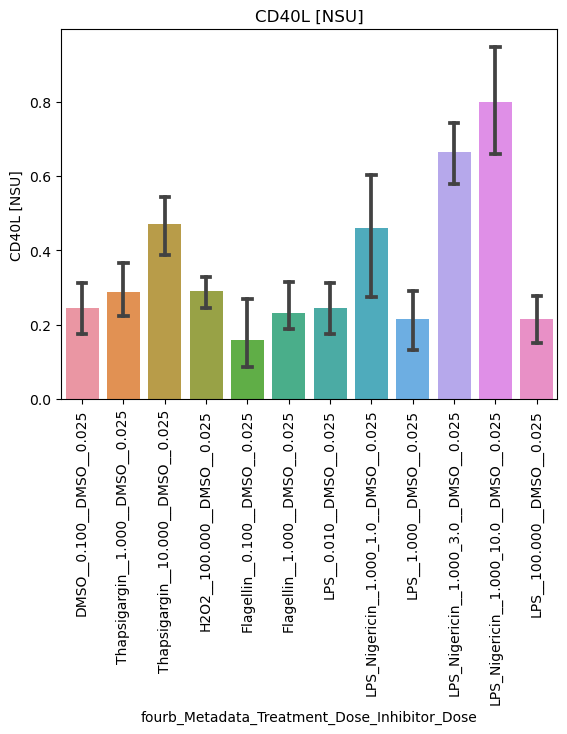

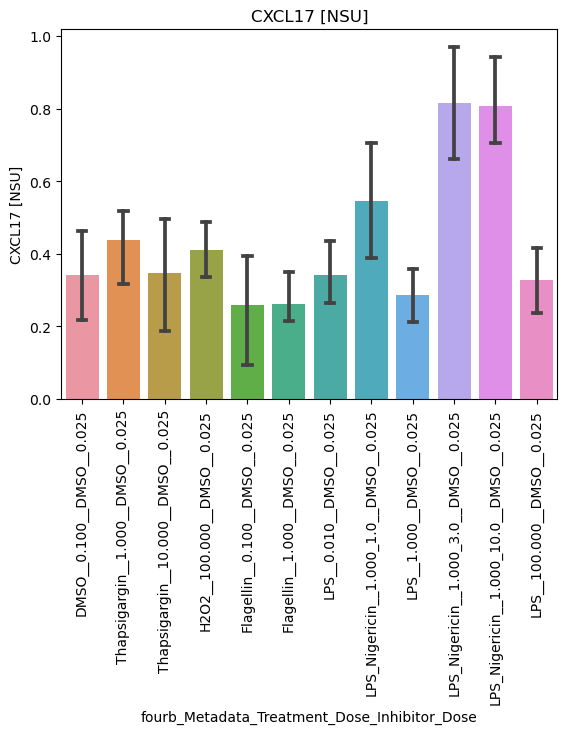

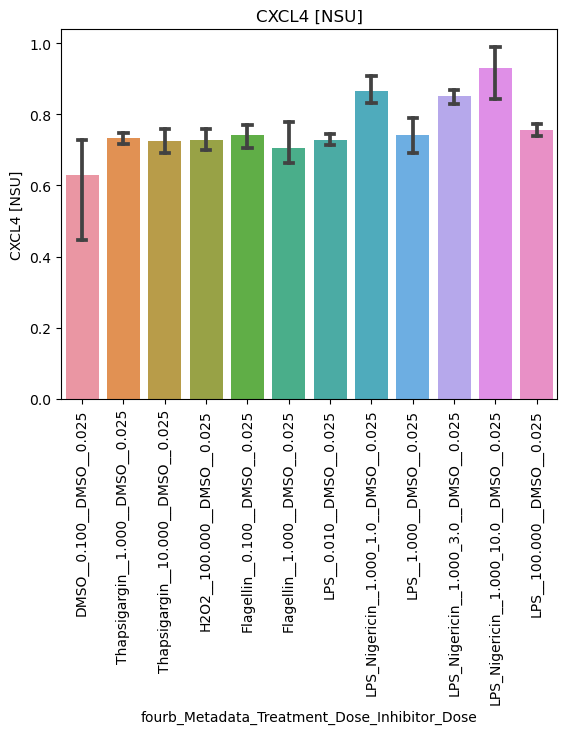

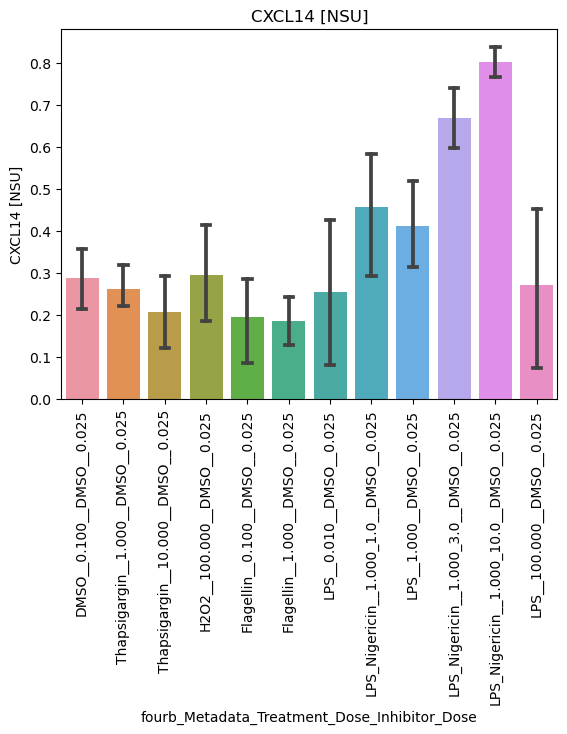

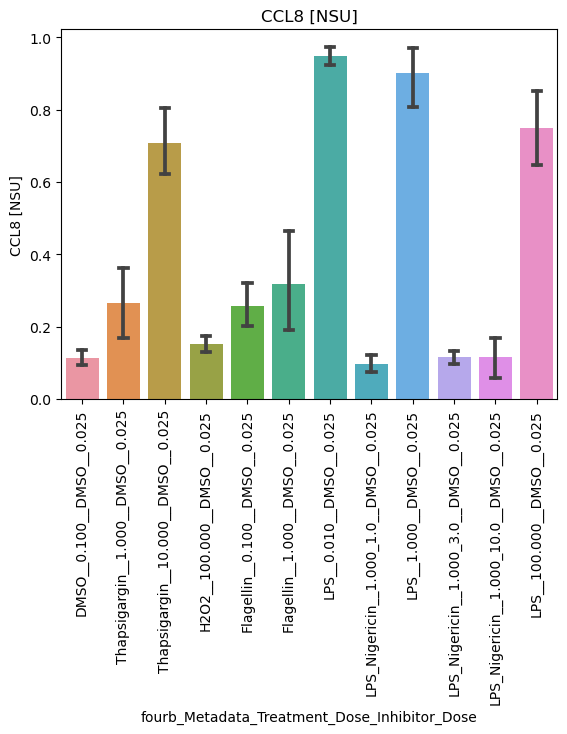

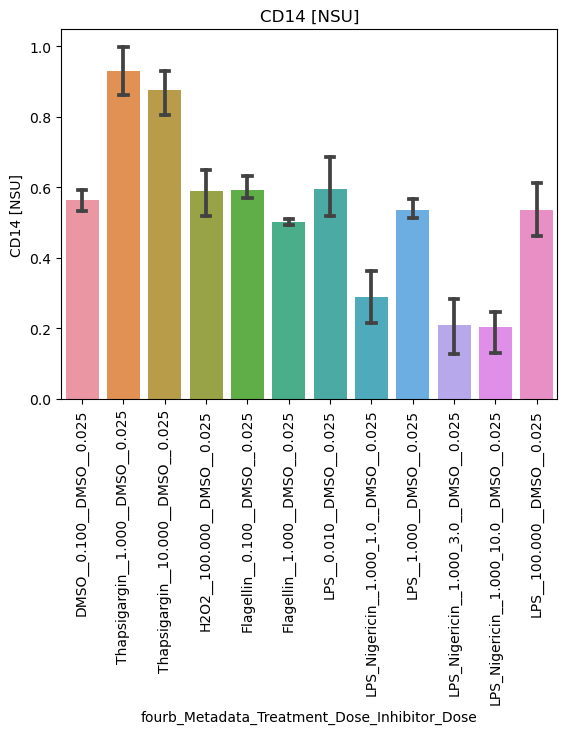

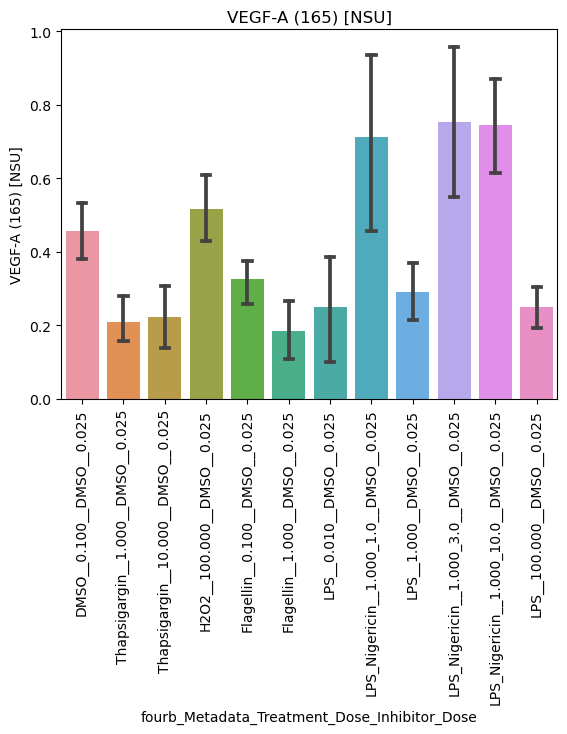

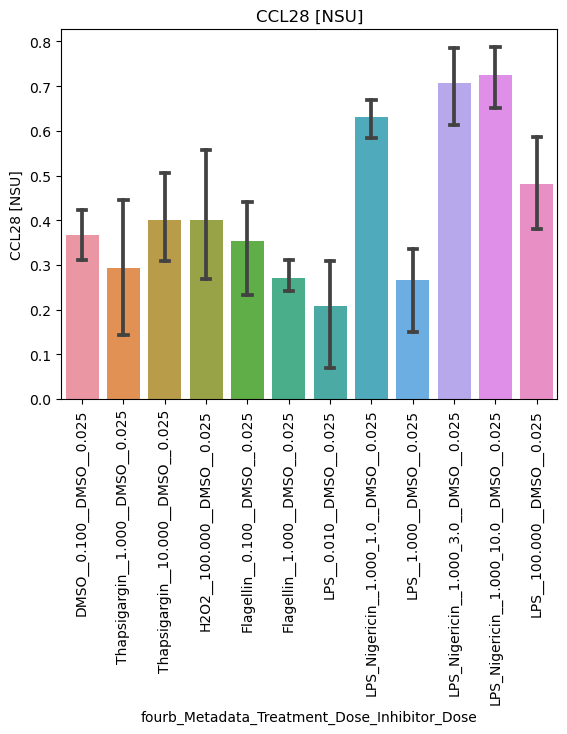

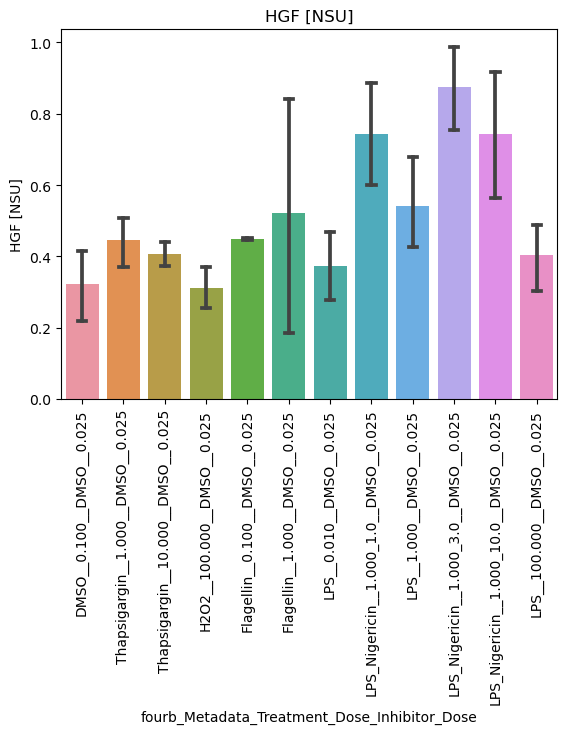

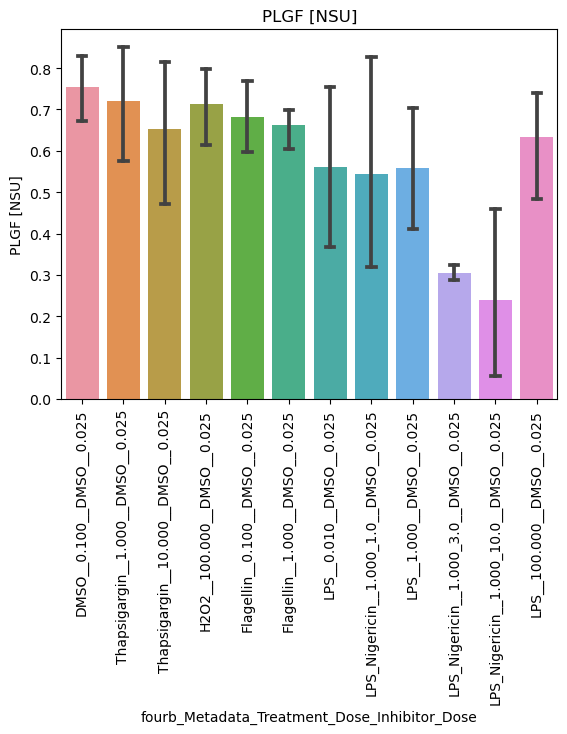

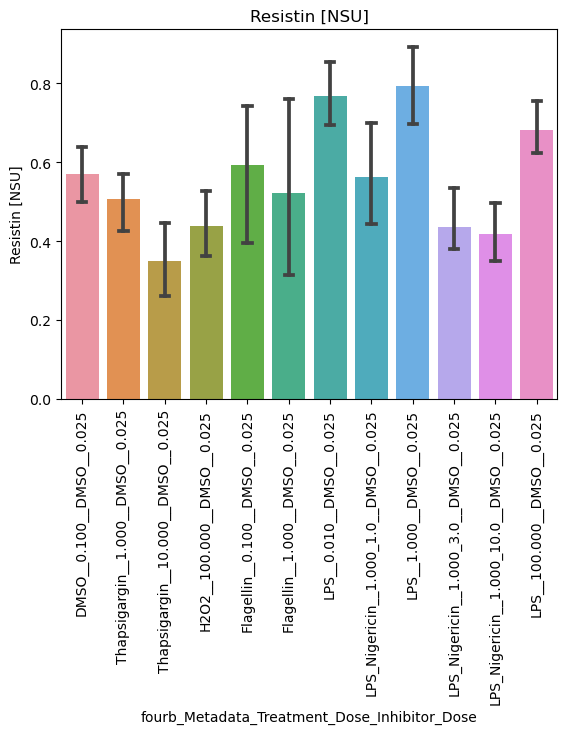

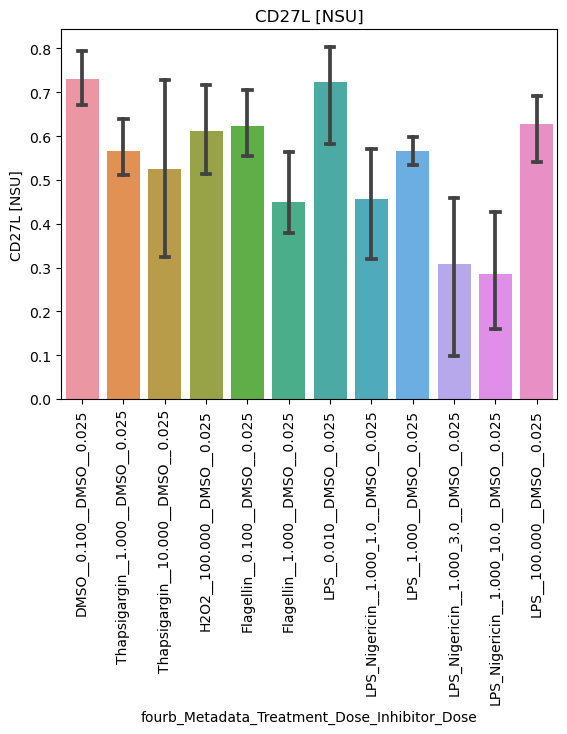

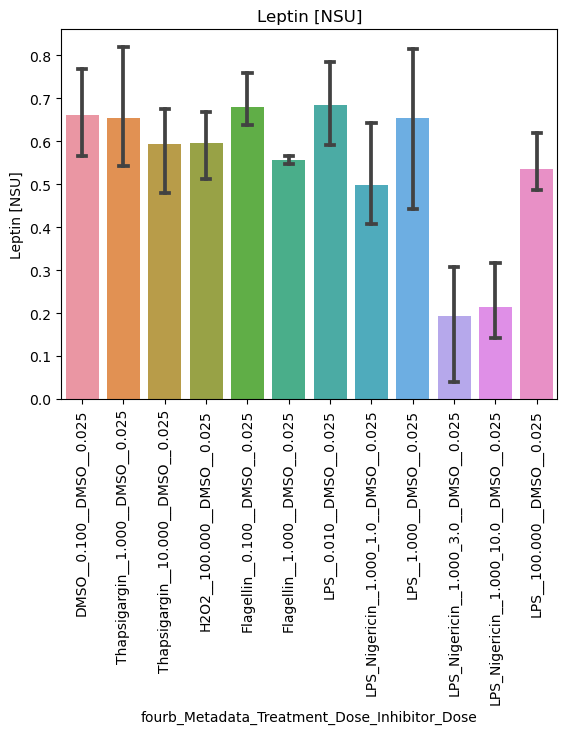

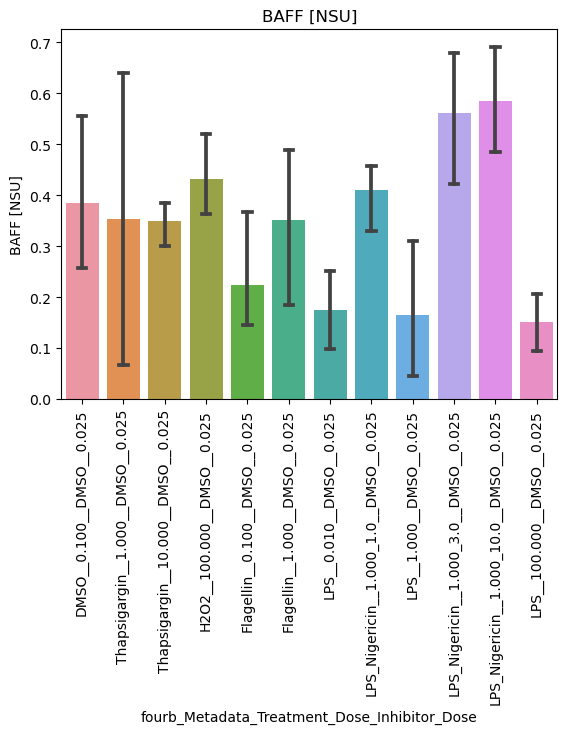

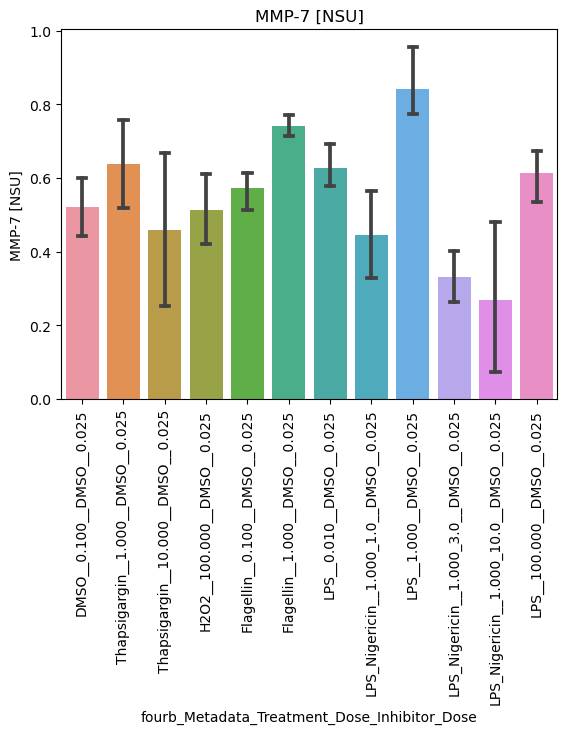

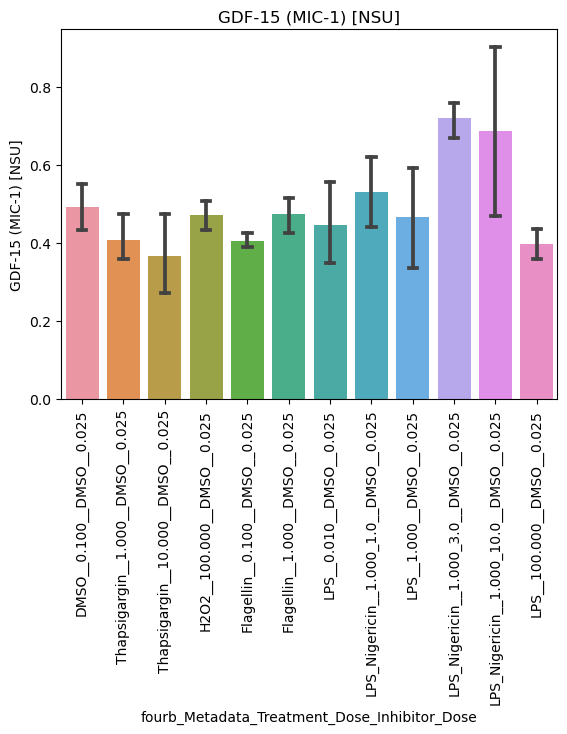

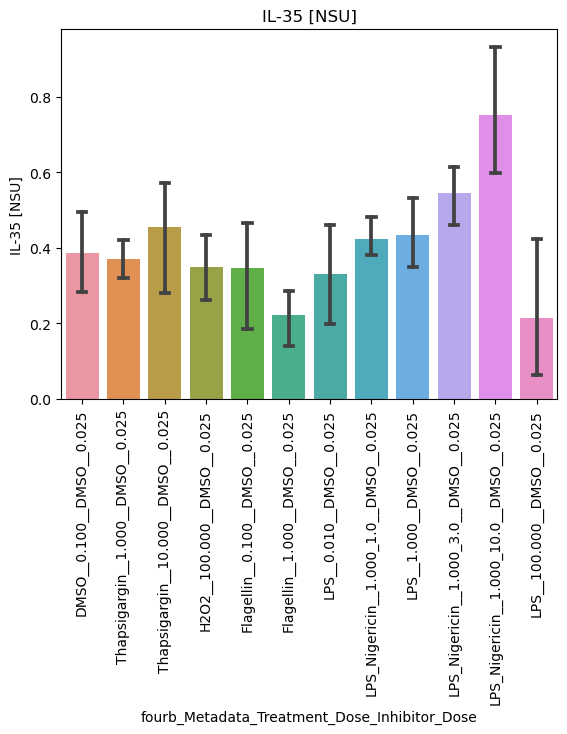

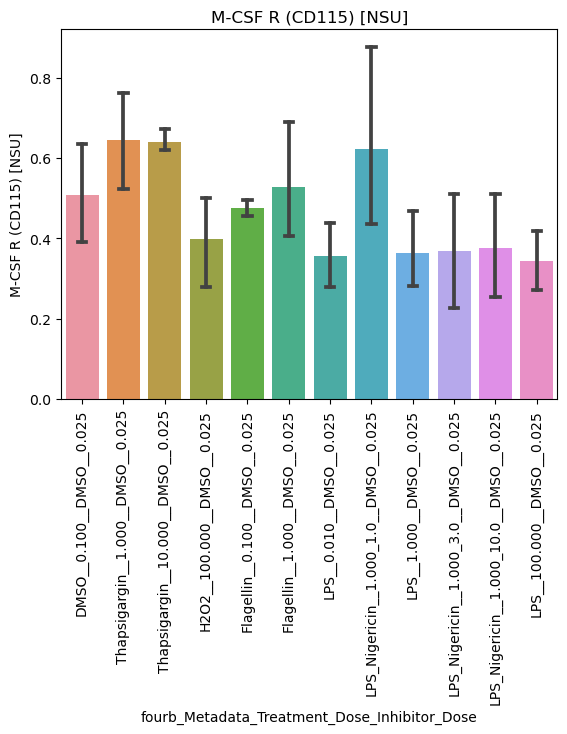

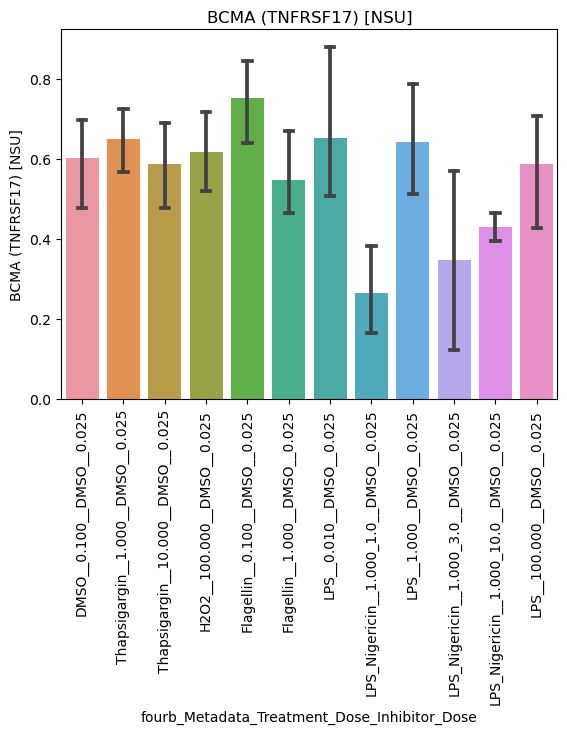

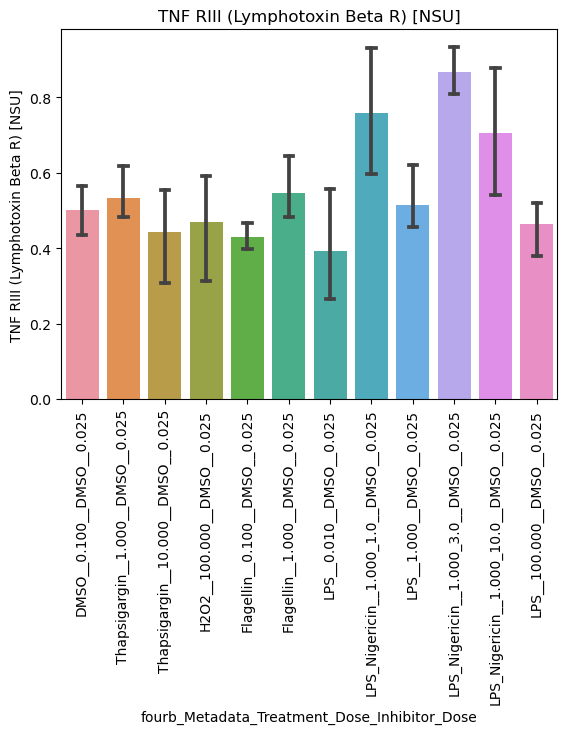

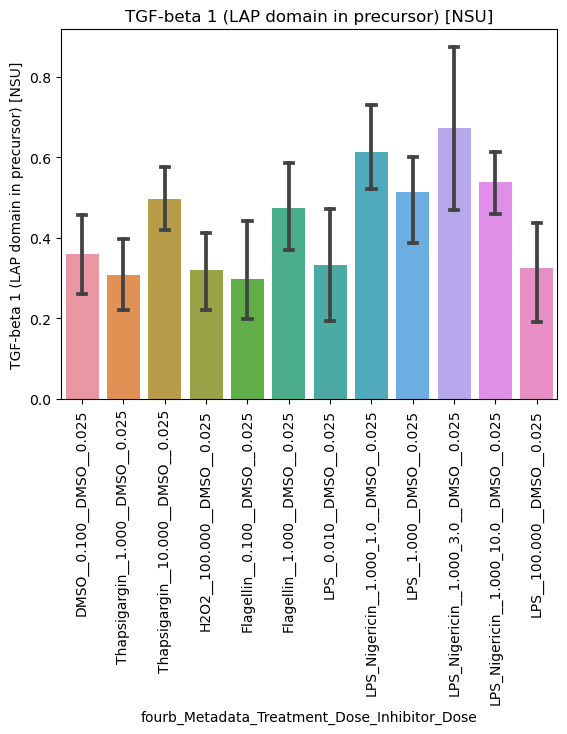

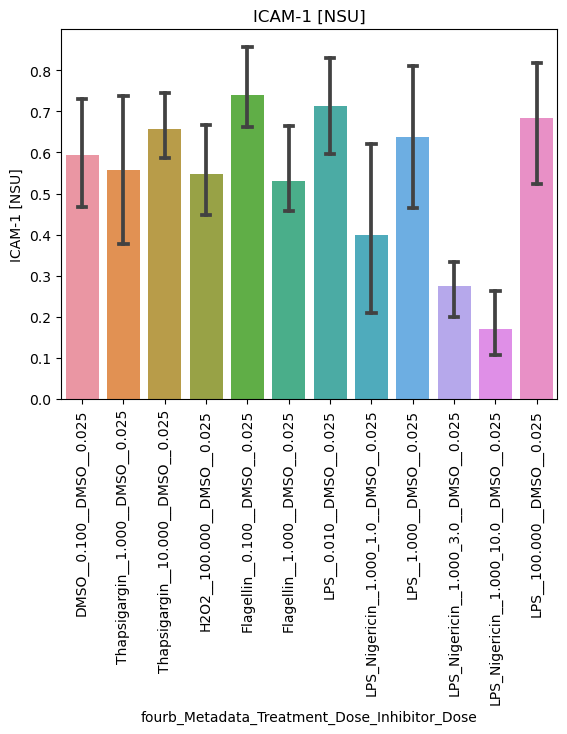

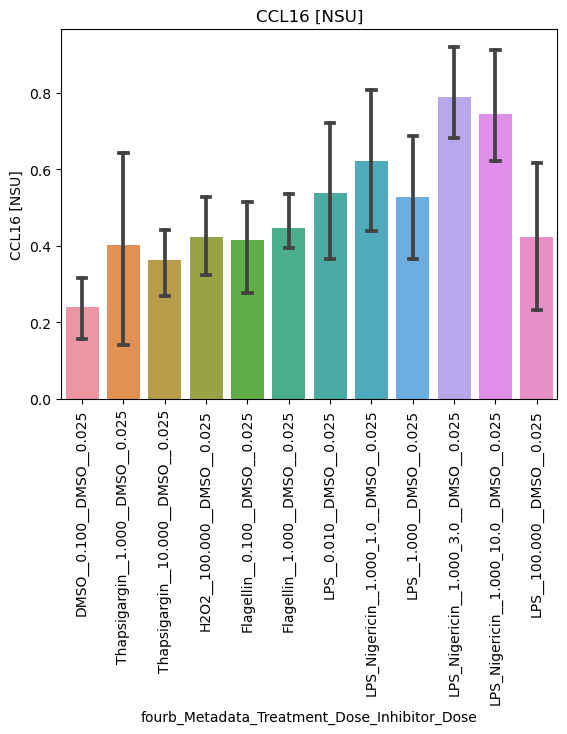

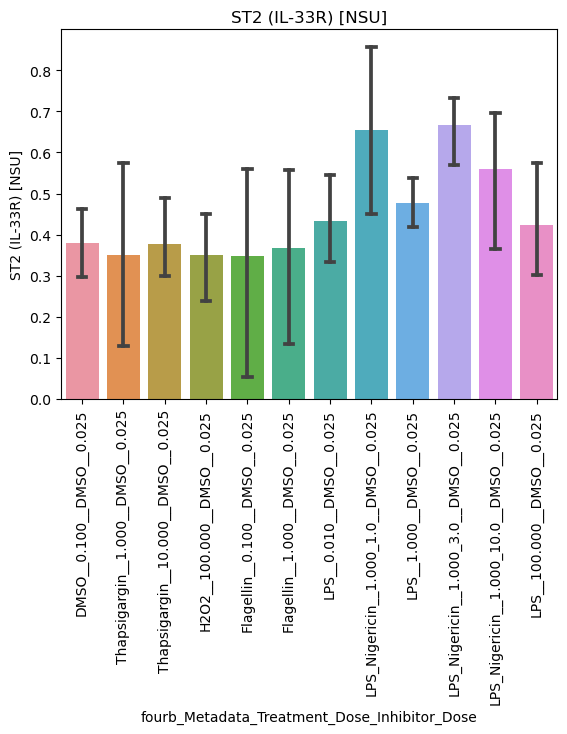

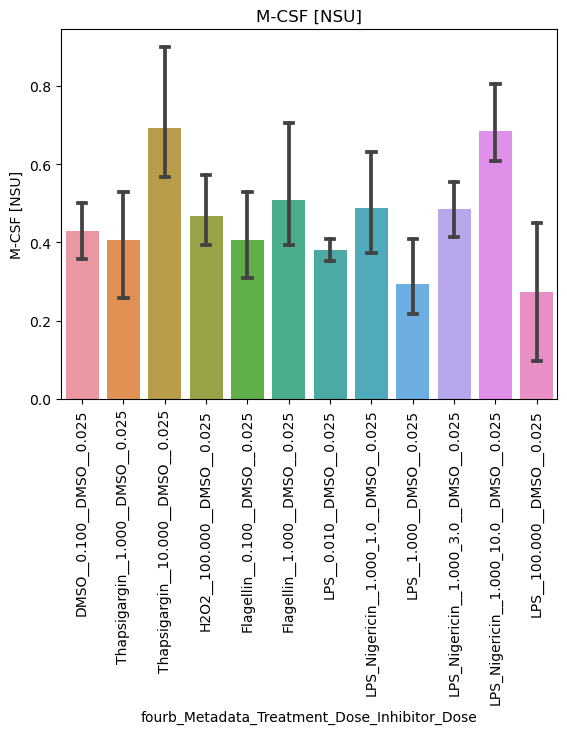

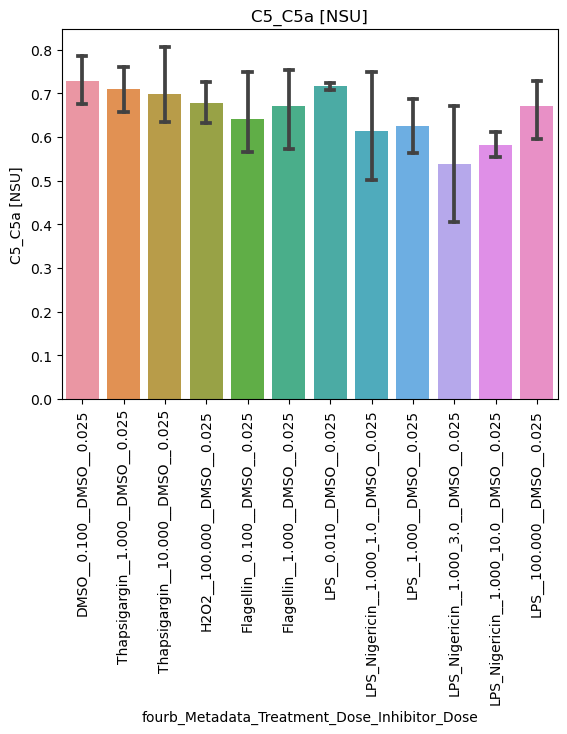

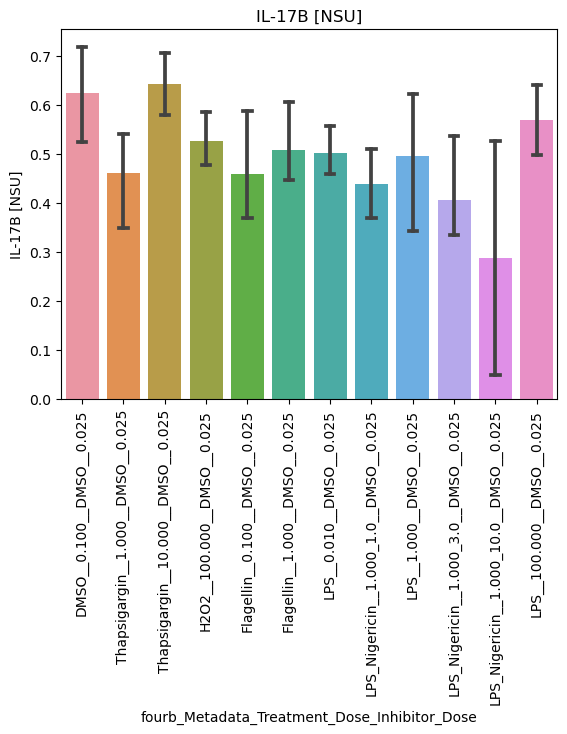

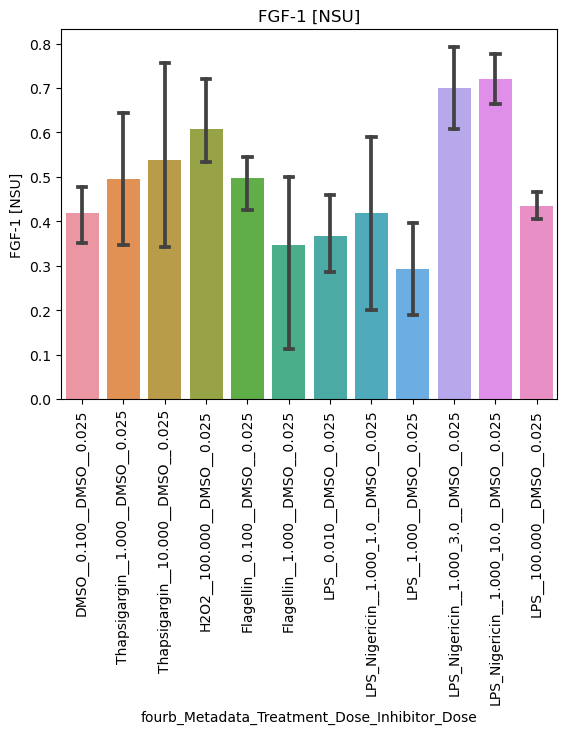

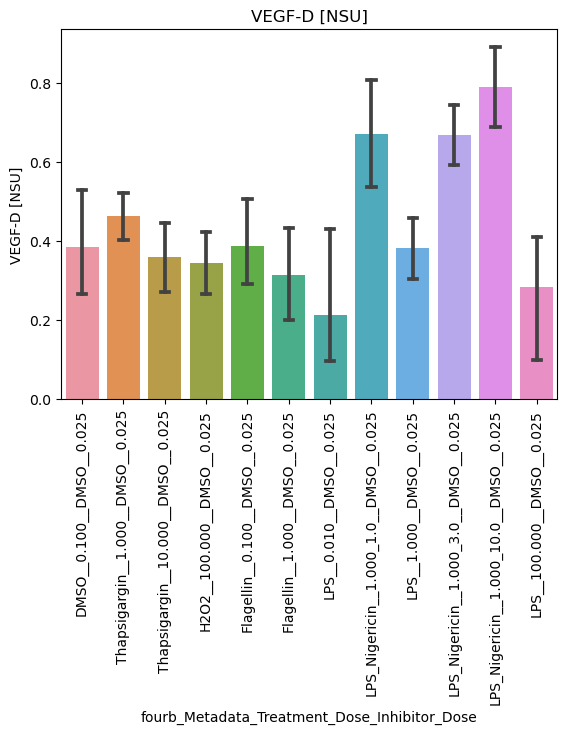

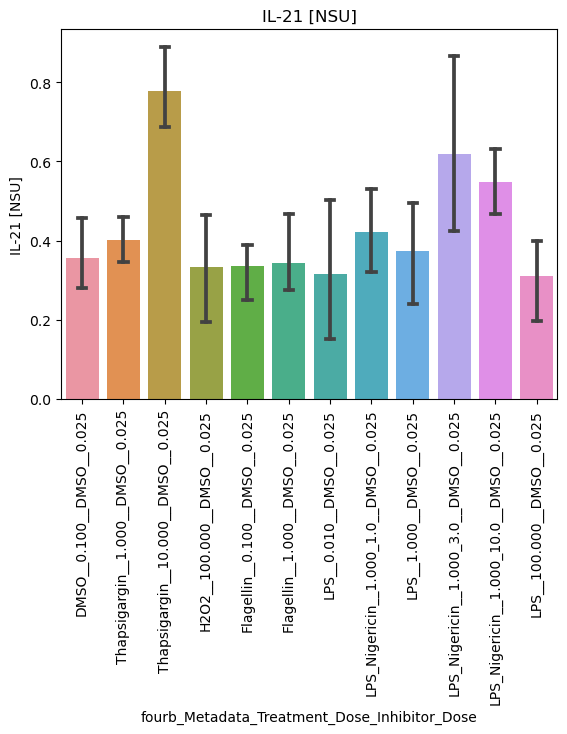

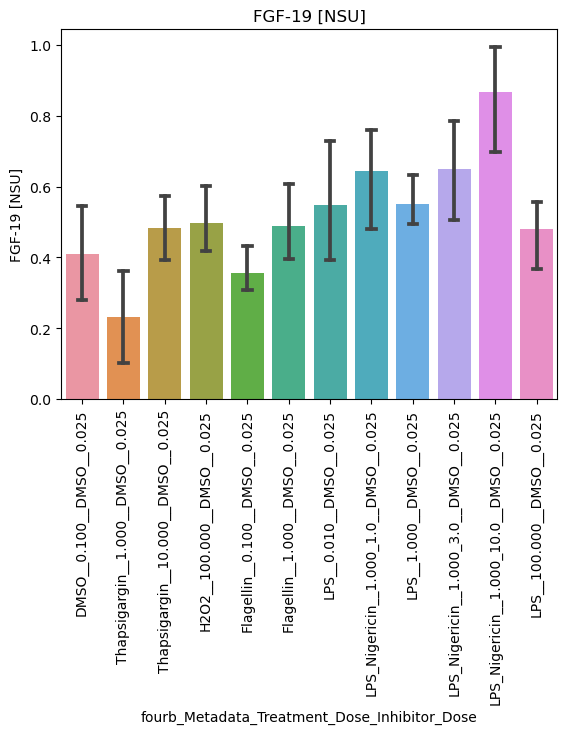

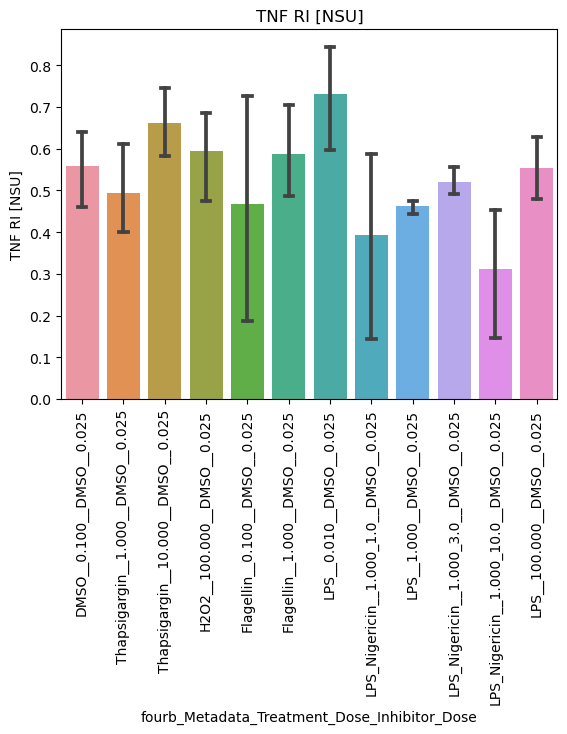

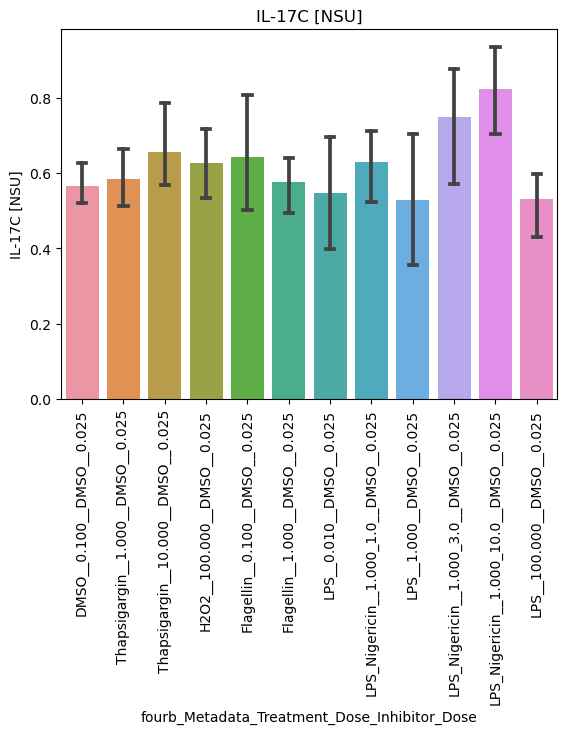

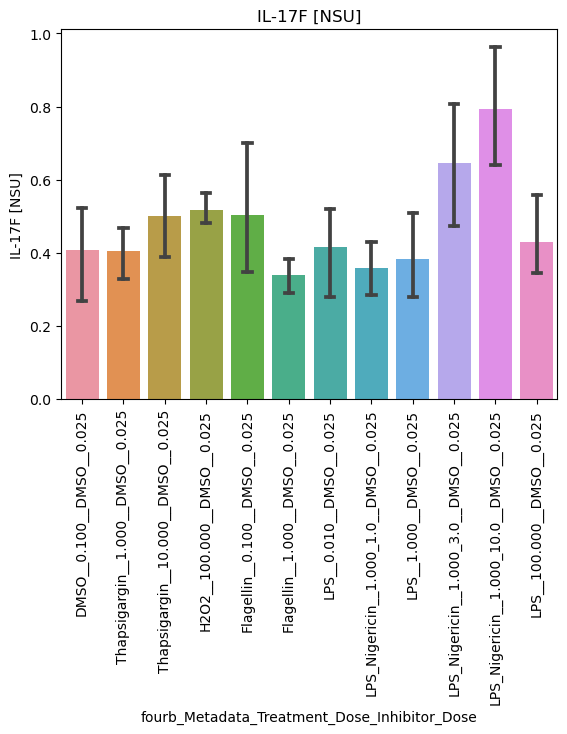

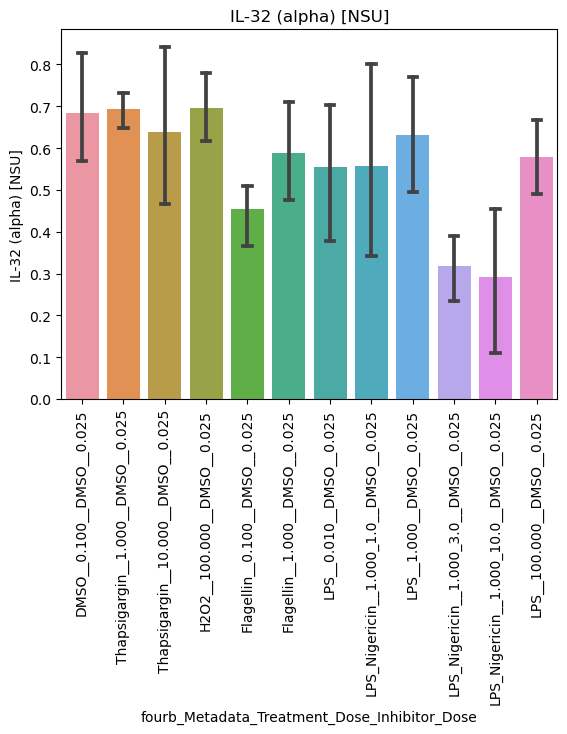

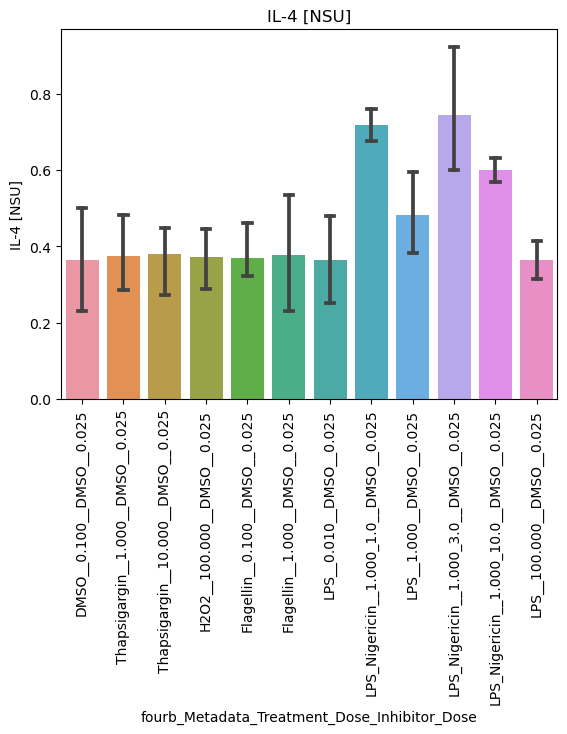

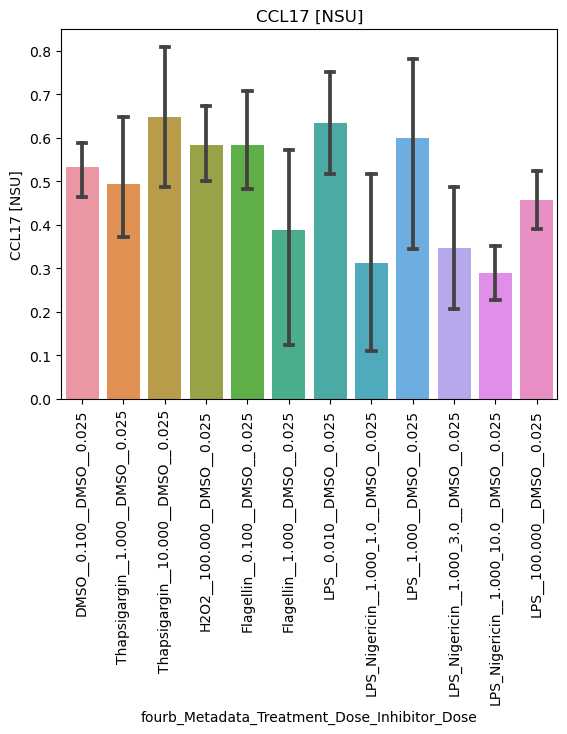

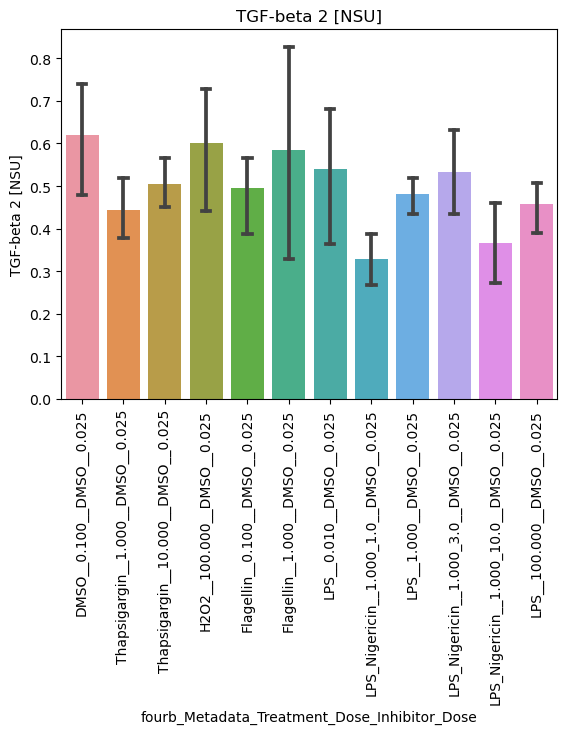

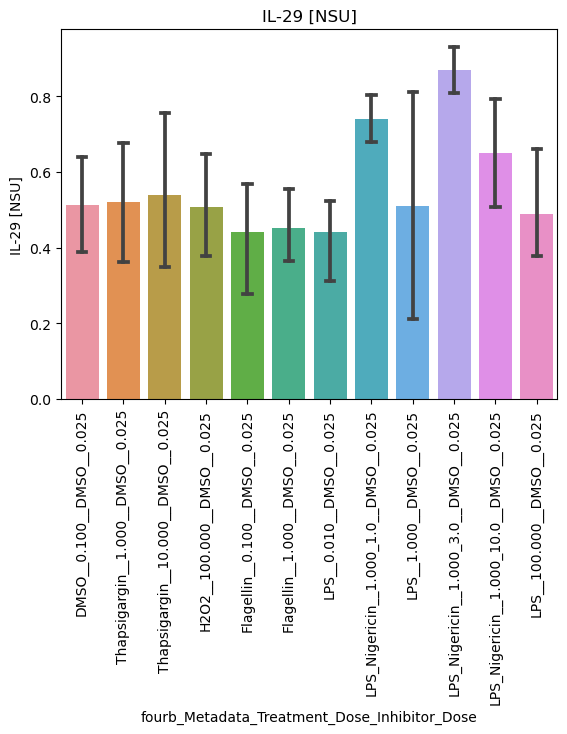

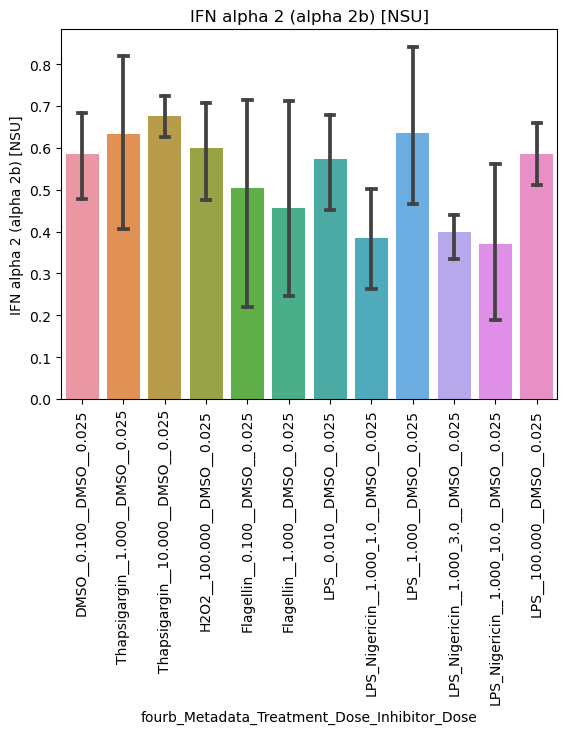

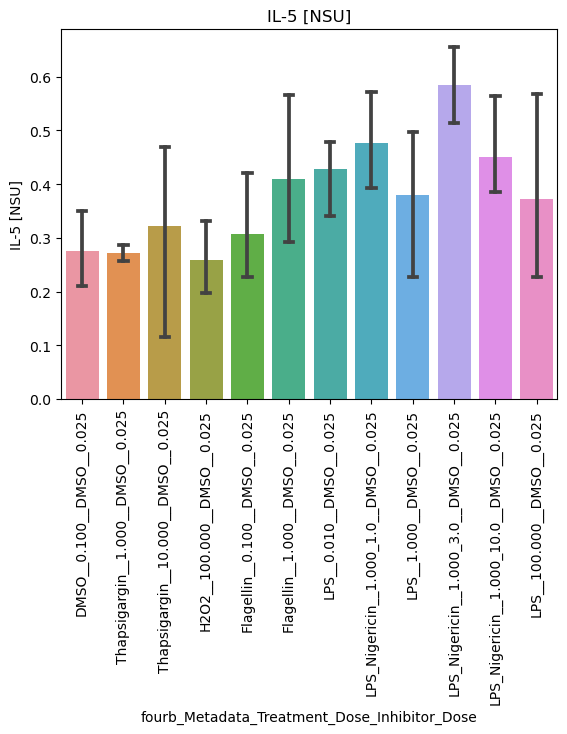

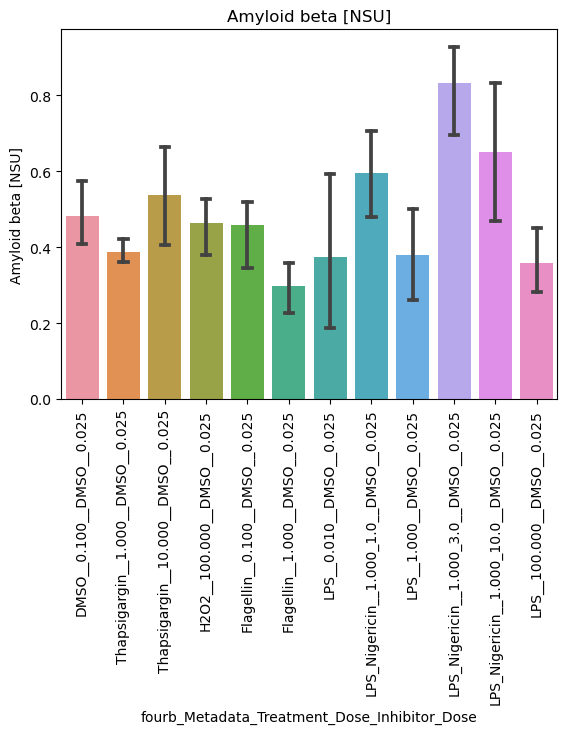

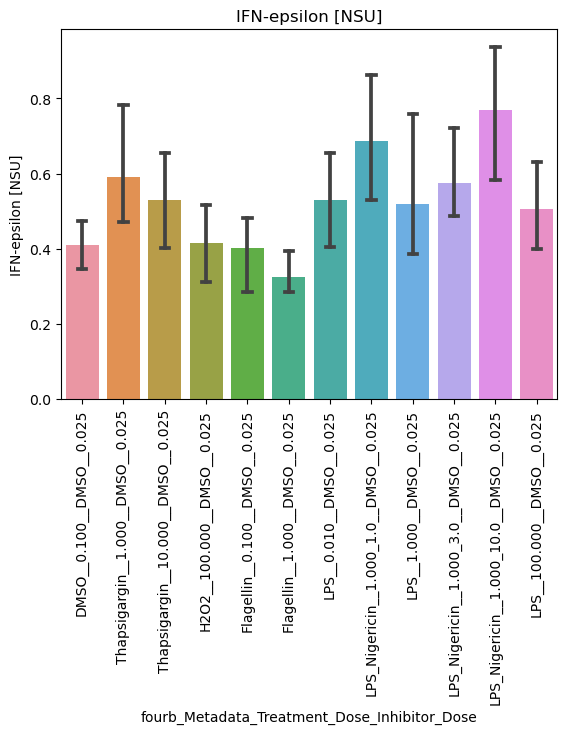

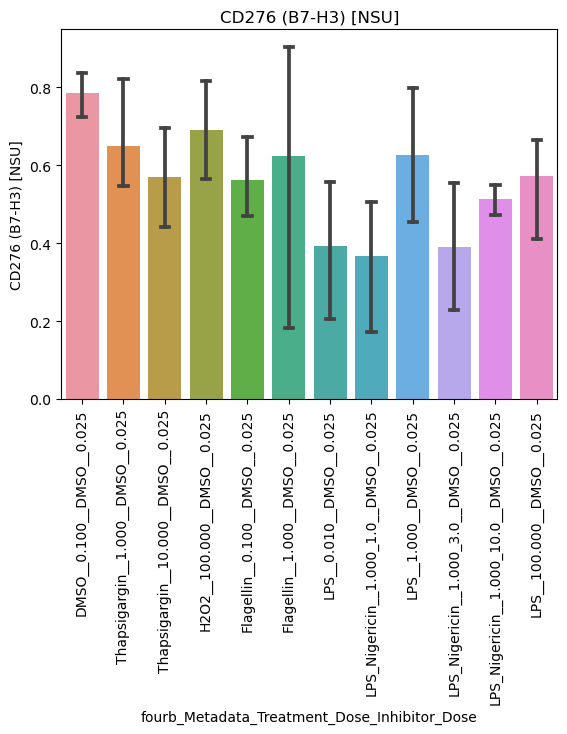

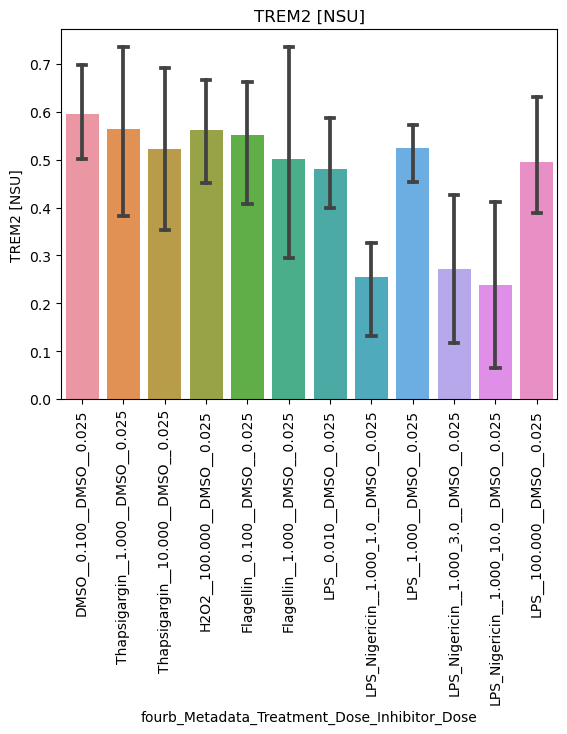

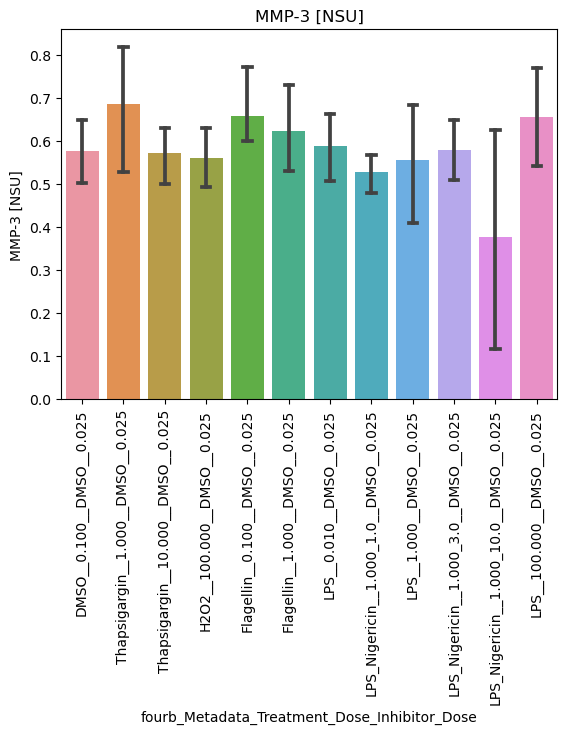

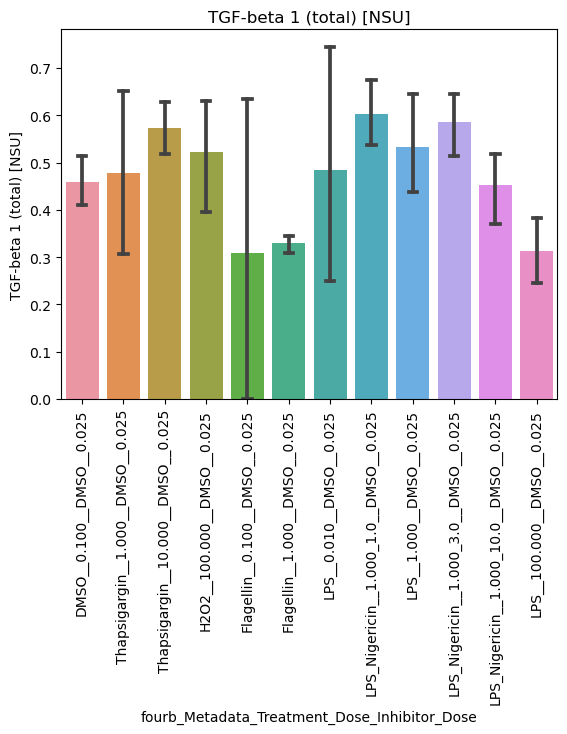

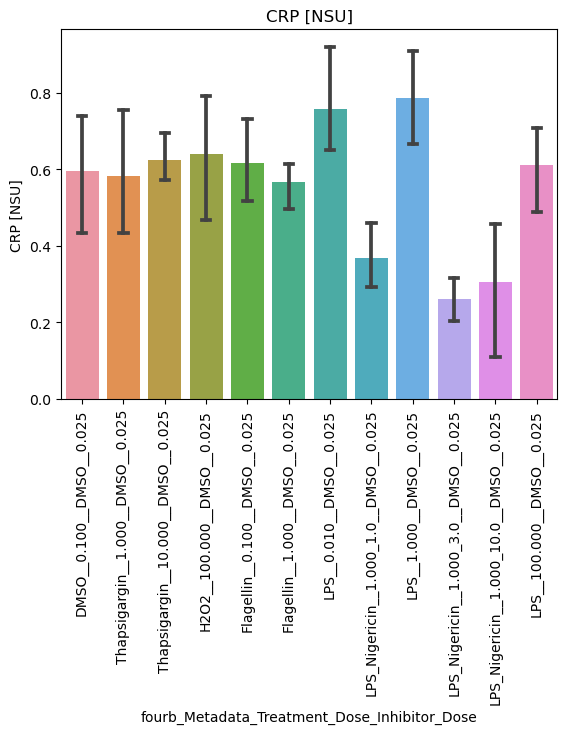

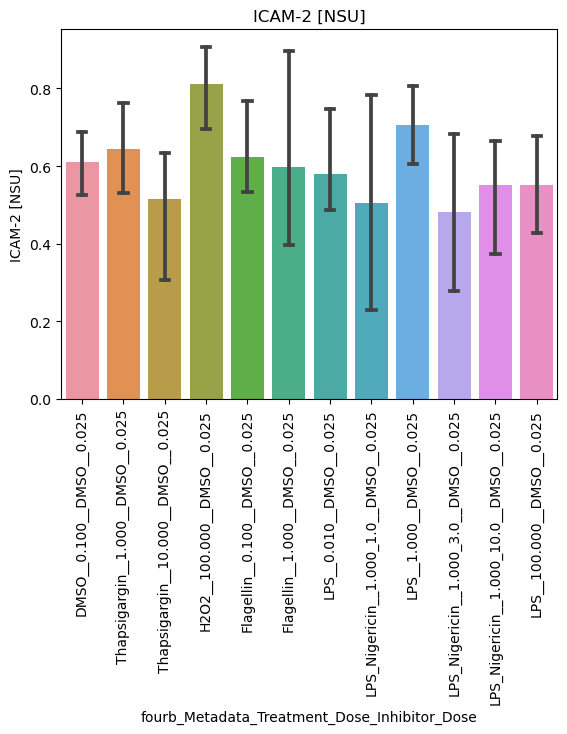

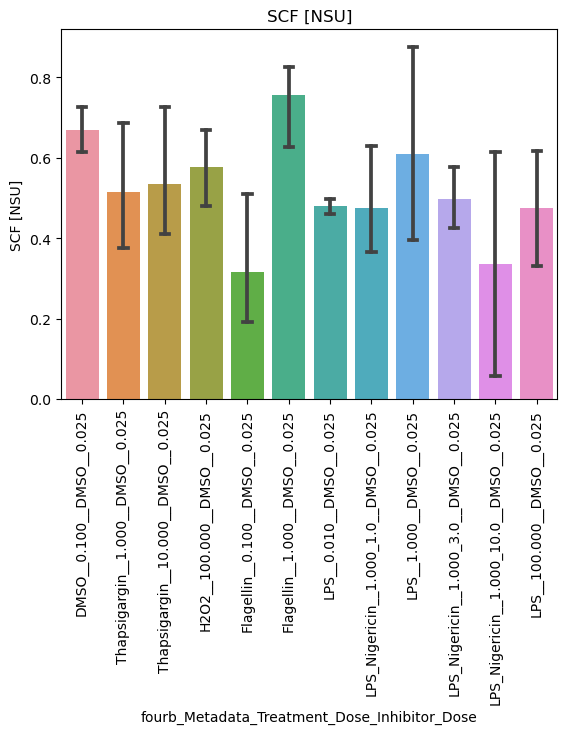

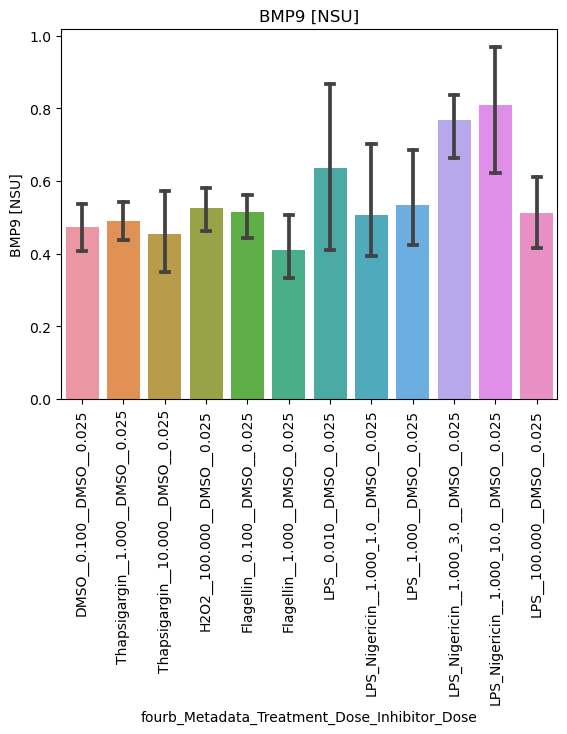

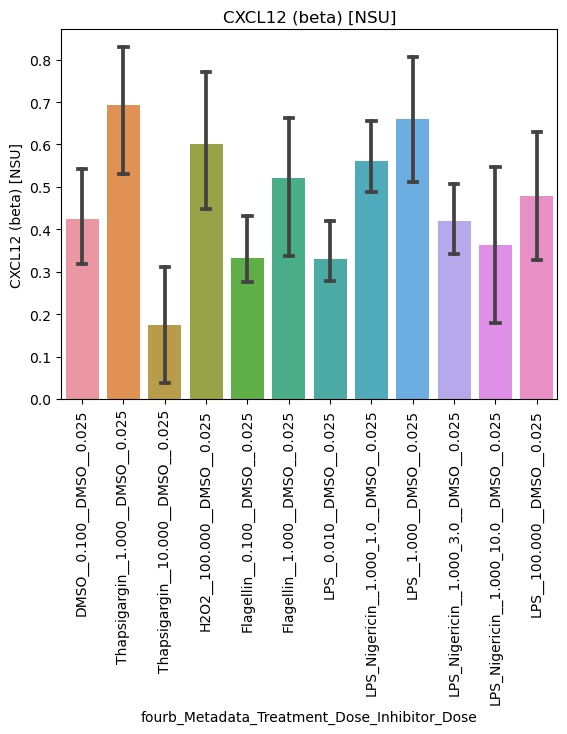

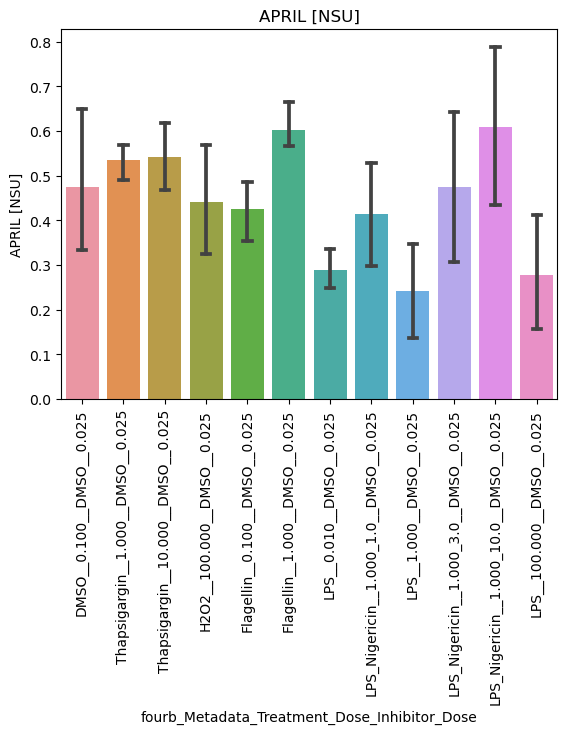

In [12]:
# graph each cytokine
for col in final_df_tukey["cytokine"].unique():
    sns.barplot(
        x="fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        y=col,
        data=df,
        capsize=0.2,
        order=list_of_treatments,
    )
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show()
# feature pick
cytokines = [
    "Activin A [NSU]",
    "IL-1 alpha [NSU]",
    "IL-1 beta [NSU]",
    "Oncostatin M (OSM) [NSU]",
    "IFN gamma [NSU]",
    "Osteopontin (OPN) [NSU]",
    "TNF alpha [NSU]",
    "EMMPRIN [NSU]",
    "G-CSF [NSU]",
    "MMP-9 [NSU]",
    "IL-6 [NSU]",
    "MIF [NSU]",
    "IL-16 [NSU]",
    "IL-22 [NSU]",
    "IL-18 [NSU]",
    "CCL24 [NSU]",
    "CCL20 [NSU]",
    "CXCL11 [NSU]",
    "CXCL1 [NSU]",
]

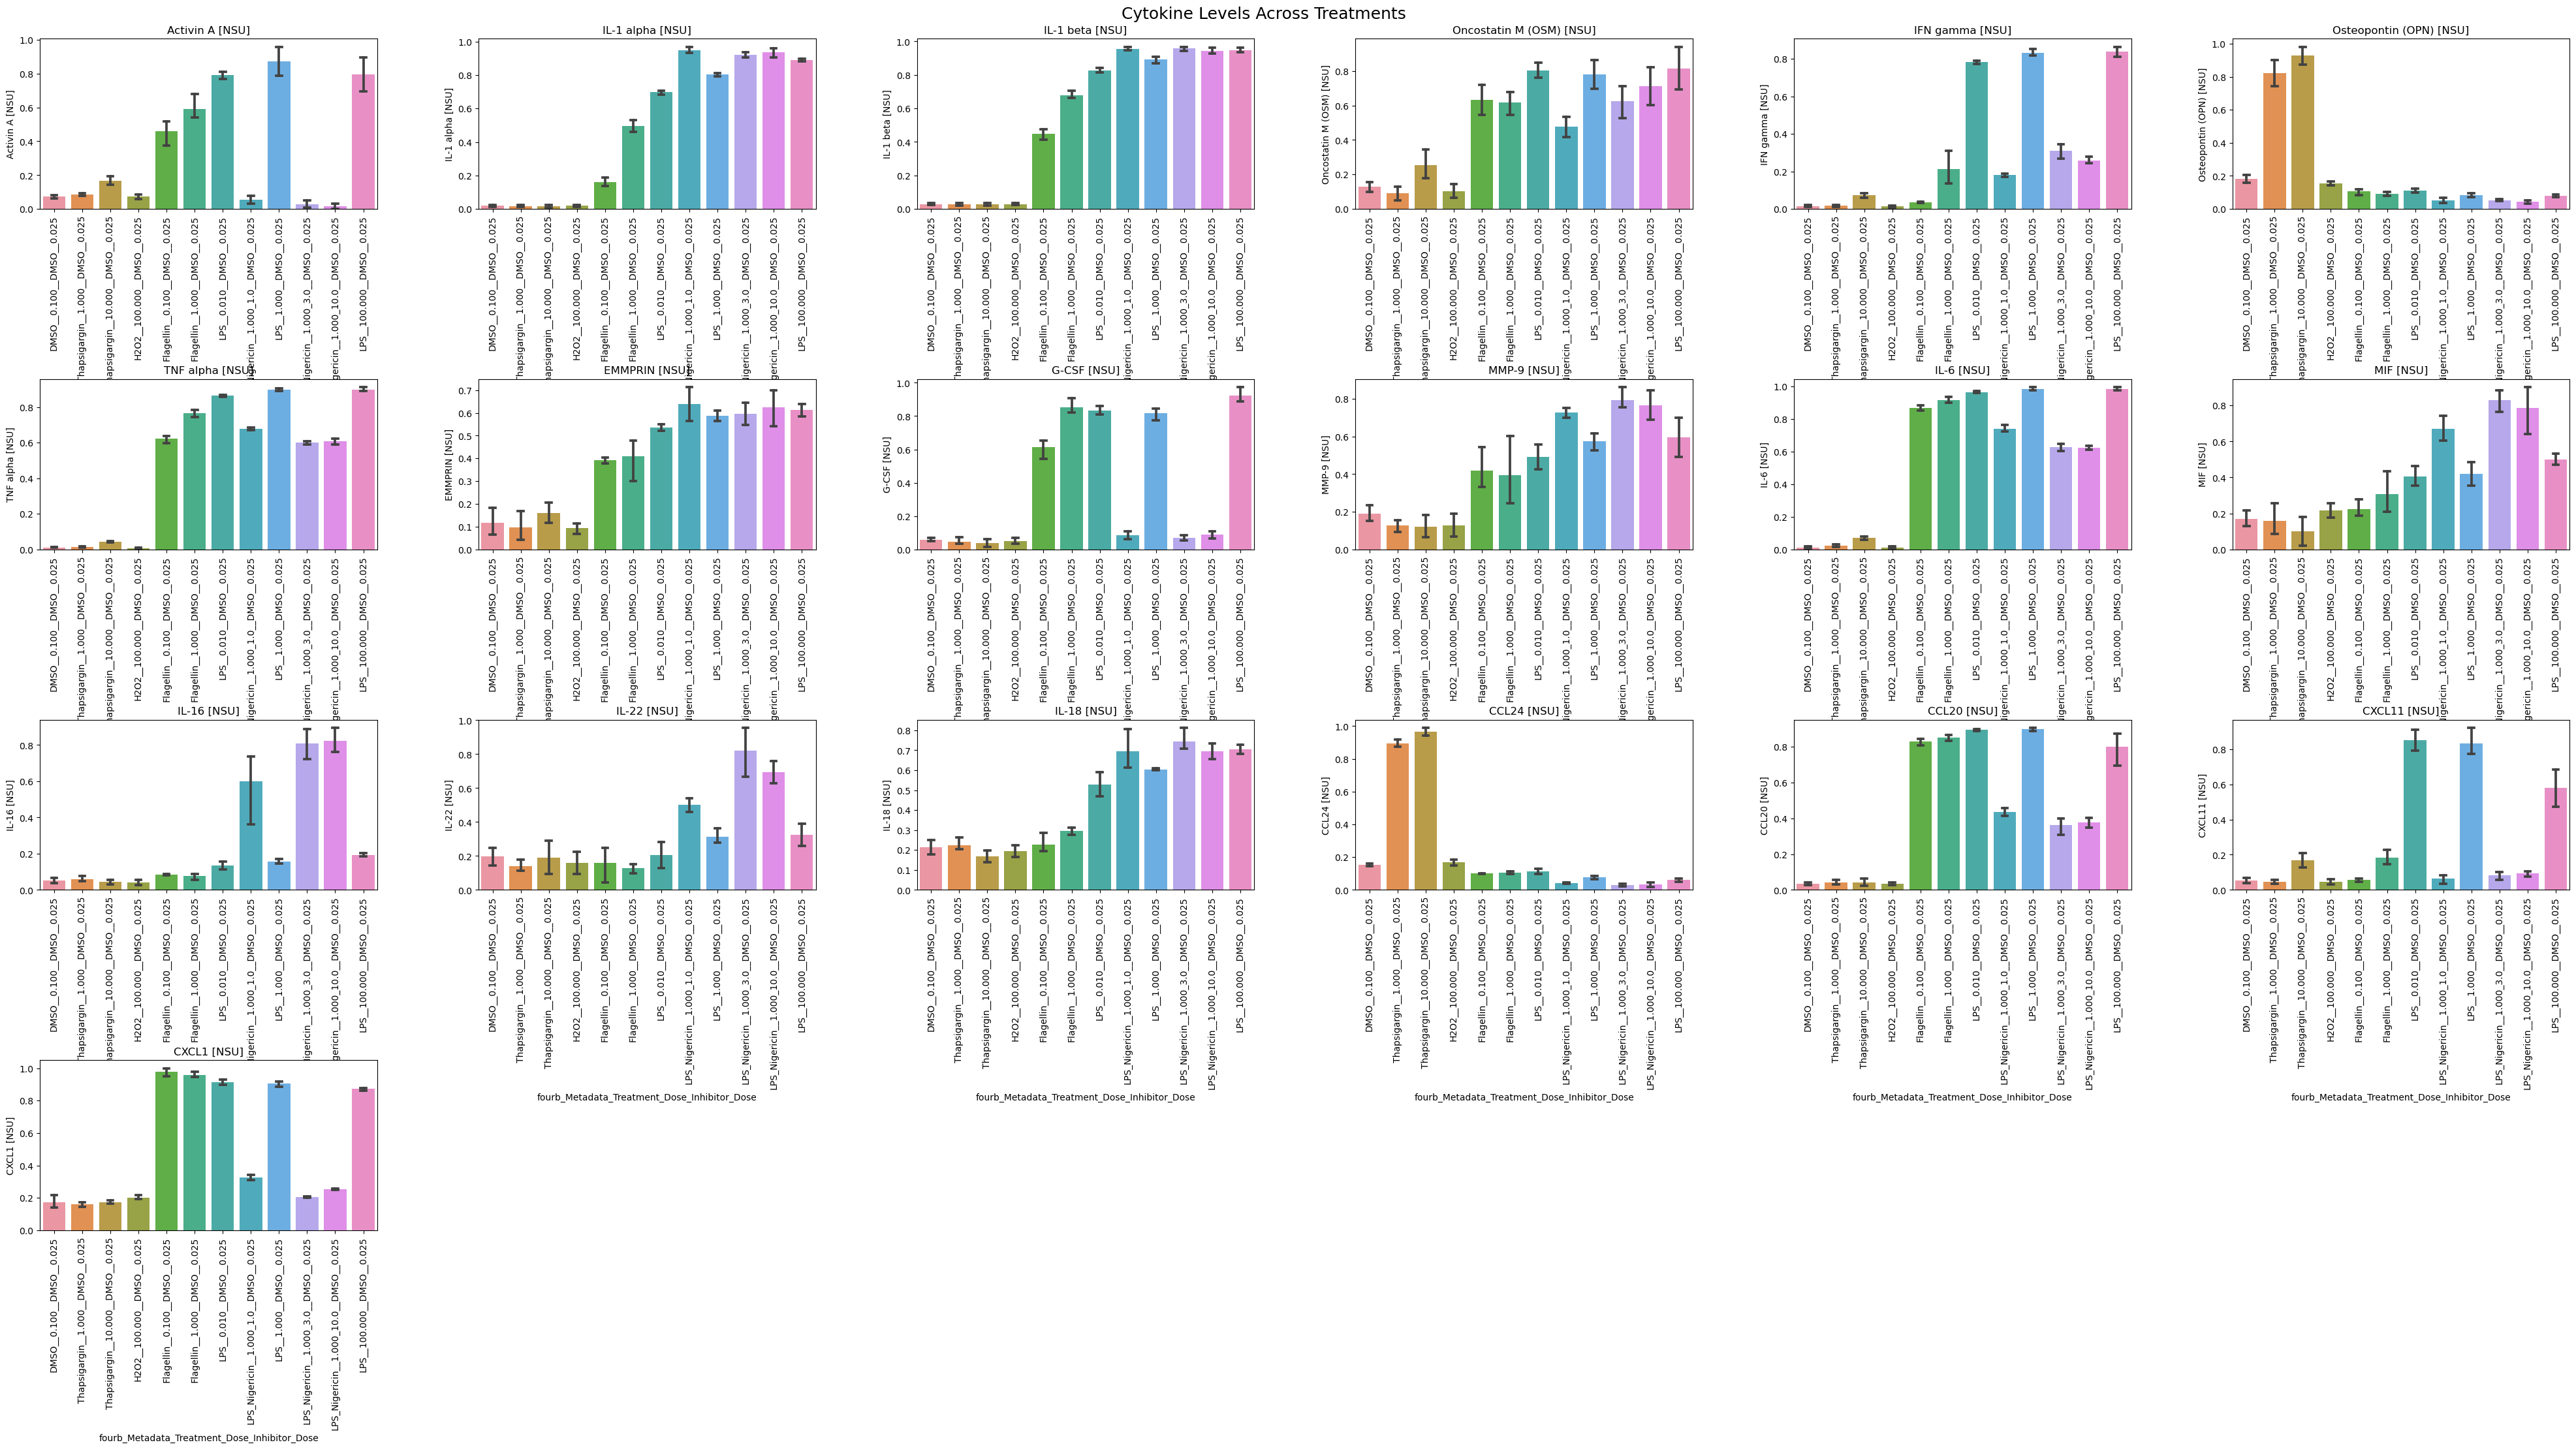

In [13]:
# drop all columns that are not in cytokines list
selected_cytokines = df[cytokines]


# plot the results of the tukey test for each cytokine
a = len(selected_cytokines.columns)
b = 6
plt.figure(figsize=(50, 100))
plt.suptitle("Cytokine Levels Across Treatments", fontsize=18)
plt.subplots_adjust(top=0.975, bottom=0.01, hspace=1, wspace=0.3)
# plt.tight_layout()
# plt.tight_layout()
for col in enumerate(selected_cytokines.columns):
    # print(col)
    # barplot with confidence intervals for col in final_df_tukey['cytokine'].unique():
    # plt.figure(figsize=(6, 4))
    plt.subplot(a, b, col[0] + 1)
    sns.barplot(
        x="fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        y=col[1],
        data=df,
        capsize=0.2,
        order=list_of_treatments,
    )
    # # title
    plt.title(col[1])
    # rotate xticks 90 degrees
    plt.xticks(rotation=90)
# set path for saving plot
pathlib.Path(f"./figures/").mkdir(parents=True, exist_ok=True)
# save plot
plt.savefig(f"./figures/selected_cytokines.png", bbox_inches="tight")
# # show plot
plt.show()
# # close plot
# # plt.close()

In [14]:
# save the final_df_tukey df to a csv file
final_df_tukey.to_csv("results/tukey_test_results.csv", index=False)

# write the cytokines column to a csv file
cytokines
with open("results/cytokines.csv", "w") as f:
    f.write("cytokine\n")
    for item in cytokines:
        f.write(f"{item}\n")
    f.close()

## Heatmaps of cytokine levels in each treatment

In [15]:
df_cytokines = df[cytokines]
df_cytokines = pd.concat(
    [df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"], df_cytokines], axis=1
)
df_cytokines = df_cytokines.set_index("fourb_Metadata_Treatment_Dose_Inhibitor_Dose")

In [16]:
cytokines

['Activin A [NSU]',
 'IL-1 alpha [NSU]',
 'IL-1 beta [NSU]',
 'Oncostatin M (OSM) [NSU]',
 'IFN gamma [NSU]',
 'Osteopontin (OPN) [NSU]',
 'TNF alpha [NSU]',
 'EMMPRIN [NSU]',
 'G-CSF [NSU]',
 'MMP-9 [NSU]',
 'IL-6 [NSU]',
 'MIF [NSU]',
 'IL-16 [NSU]',
 'IL-22 [NSU]',
 'IL-18 [NSU]',
 'CCL24 [NSU]',
 'CCL20 [NSU]',
 'CXCL11 [NSU]',
 'CXCL1 [NSU]']

In [17]:
# data_new['Inducer1_and_dose'] = df['Inducer1_and_dose']
# aggregate the data by treatment group via mean
data_agg = df_cytokines.groupby("fourb_Metadata_Treatment_Dose_Inhibitor_Dose").mean()
# heatmap of umap_clusters_with_cytokine_data_agg
# subset the columns to plot
column_list = [col for col in data_agg.columns if "[NSU]" in col]
# subset the rows to plot and label the rows with treatment groups
row_list = data_agg.index
# subset the data to plot
data = data_agg[column_list]

In [18]:
# order the rows by treatment group
data_agg = data_agg.reindex(list_of_treatments, axis=0)

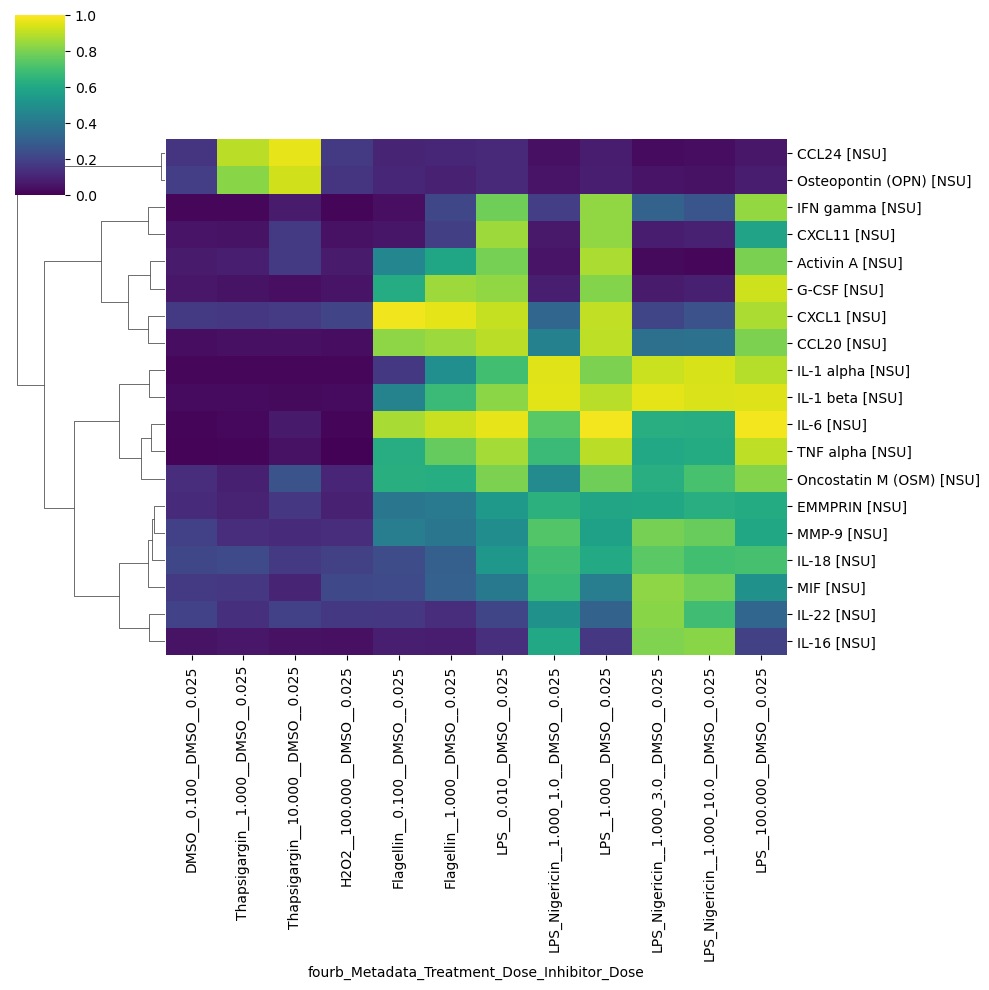

In [19]:
# create the heatmap with dendrogram and cluster the rows and columns with the euclidean distance metric
# order the rows and columns by the linkage matrix generated by the clustering algorithm
# import linkage from scipy.cluster.hierarchy to cluster the rows and columns
# define the linkage matrix
linkage_df = linkage(
    data_agg.T, metric="euclidean", method="ward", optimal_ordering=True
)
g = sns.clustermap(
    data_agg.T,
    cmap="viridis",
    metric="euclidean",
    method="ward",
    row_cluster=True,
    col_cluster=False,
    row_linkage=linkage_df,
    col_linkage=linkage_df,
    xticklabels=True,
    yticklabels=True,
    vmin=0,
    vmax=1,
    # cbar_kws={"label": "Cytokine Levels"},
    # dendrogram_ratio=0.25,
    # set colorbar position to the right
    # cbar_pos=(1.02, 0.25, 0.03, 0.5),
    # set plot size
    # figsize=(25, 25),
)
# change the font size of the x and y ticks
# g.ax_heatmap.tick_params(labelsize=20)
# g.ax_heatmap.set_xlabel("Cytokines", fontsize=30)

# save the heatmap
plt.savefig("./figures/heatmap_PBMC.png", bbox_inches="tight")
# show the heatmap
plt.show()